# Data Cleaning

## Import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import pprint

# For converting past dollars to 2018 dollars
# https://github.com/datadesk/cpi
import cpi

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import Box Office Mojo dataset and fix small issues

We read in the Box Office Mojo.

We remove redundant columns and rename the labels with `_mojo` suffixes to avoid confusion. 

We skip the columns `title` and `release_year` though, since we will be joining on those columns.

In [ ]:
mojo = pd.read_csv("movie_data.csv", parse_dates=["release_date_formatted"])

mojo.drop(labels=[
    'runtime',
    'release_date',
    'domestic_gross',
    'foreign_gross',
    'worldwide_gross',
    'adjusted_domestic_gross_2019'
], axis=1, inplace=True)

mojo.rename(mapper={
    'distributor': 'distributor_mojo',
    'rating': 'rating_mojo',
    'genres': 'genres_mojo',
    'production_budget': 'production_budget_mojo',
    'runtime_formatted': 'runtime_mojo',
    'release_date_formatted': 'release_date_mojo',
    'domestic_gross_formatted': 'domestic_gross_mojo',
    'foreign_gross_formatted': 'foreign_gross_mojo',
    'worldwide_gross_formatted': 'worldwide_gross_mojo',
    'adjusted_domestic_gross_2019_formatted': 'adjusted_domestic_gross_2019_mojo',
    'director1': 'director1_mojo',
    'director2': 'director2_mojo',
    'writer1': 'writer1_mojo',
    'writer2': 'writer2_mojo',
    'writer3': 'writer3_mojo',
    'actor1': 'actor1_mojo',
    'actor2': 'actor2_mojo',
    'actor3': 'actor3_mojo',
    'actor4': 'actor4_mojo',
    'actor5': 'actor5_mojo',
    'actor6': 'actor6_mojo',
    'producer1': 'producer1_mojo',
    'producer2': 'producer2_mojo',
    'producer3': 'producer3_mojo',
    'producer4': 'producer4_mojo',
    'producer5': 'producer5_mojo',
    'producer6': 'producer6_mojo',
    'cinematographer': 'cinematographer_mojo',
    'composer1': 'composer1_mojo',
    'composer2': 'composer2_mojo'
}, axis=1, inplace=True)

# Cast `release_year` as Nullable Integer Data Type to allow comparisons as integers and still have np.nan values
mojo['release_year'] = mojo['release_date_mojo'].dt.year.astype("Int64")

mojo['runtime_mojo'] = mojo['runtime_mojo'].astype("Int64")

# Reorder the columns 
mojo = mojo[['title', 'release_year', 'release_date_mojo', 'distributor_mojo', 'runtime_mojo',
             'rating_mojo', 'genres_mojo', 'production_budget_mojo', 'domestic_gross_mojo',
             'foreign_gross_mojo', 'worldwide_gross_mojo', 'adjusted_domestic_gross_2019_mojo', 'director1_mojo',
             'director2_mojo', 'writer1_mojo', 'writer2_mojo', 'writer3_mojo', 'actor1_mojo', 'actor2_mojo', 'actor3_mojo', 'actor4_mojo', 'actor5_mojo', 
             'actor6_mojo', 'producer1_mojo', 'producer2_mojo', 'producer3_mojo', 'producer4_mojo', 'producer5_mojo', 'producer6_mojo', 'cinematographer_mojo',
             'composer1_mojo', 'composer2_mojo']]

# Only analyze movies that were released up to 2018 to prevent incomplete box office numbers
mojo = mojo[~(mojo['release_year'] > 2018)]

# We only want entries that have a title
mojo = mojo[~mojo['title'].isna()]

# We will drop any duplicate rows
mojo.drop_duplicates(inplace=True)

In [ ]:
mojo.info()

###  Fix `production-budget_mojo` column

We must properly convert `production_budget_mojo` into a numeric form.

Right now, it has entries like `$30 million` in it.

There are a couple bad entries in it (e.g. `PG` and `Unrated`) from a bad web-scrape that we will fix. Doing some research, the websites for the movie in question is `https://www.boxofficemojo.com/movies/?id=picnicathangingrock98.htm` and `https://www.boxofficemojo.com/movies/?id=zyzzyxroad.htm`.

In [ ]:
mojo['production_budget_mojo'].value_counts(dropna=False)

#### Fix webscraping errors

Fix the `PG` entry.

In [ ]:
mojo[mojo['production_budget_mojo'] == 'PG']

In [ ]:
# From the website
mojo.at[1245, 'release_year'] = 1998
mojo.at[1245, 'release_date_mojo'] = pd.to_datetime('19980626', format='%Y%m%d', errors='ignore')
mojo.at[1245, 'distributor_mojo'] = 'Kit Parker Films'
mojo.at[1245, 'runtime_mojo'] = 107
mojo.at[1245, 'rating_mojo'] = 'PG'
mojo.at[1245, 'genres_mojo'] = 'Unknown'
mojo.at[1245, 'production_budget_mojo'] = np.nan
mojo.at[1245, 'domestic_gross_mojo'] = 232201

In [ ]:
mojo[mojo['title'] == 'Picnic at Hanging Rock (Re-issue)']

Fix the `Unrated` entry.

In [ ]:
mojo[mojo['production_budget_mojo'] == 'Unrated']

In [ ]:
# From the website
mojo.at[2746, 'release_year'] = 2006
mojo.at[2746, 'release_date_mojo'] = pd.to_datetime('20060225', format='%Y%m%d', errors='ignore')
mojo.at[2746, 'distributor_mojo'] = 'Regent Releasing'
mojo.at[2746, 'runtime_mojo'] = 90
mojo.at[2746, 'rating_mojo'] = 'Unrated'
mojo.at[2746, 'genres_mojo'] = 'Thriller'
mojo.at[2746, 'production_budget_mojo'] = '2000000'
mojo.at[2746, 'domestic_gross_mojo'] = 30

In [ ]:
mojo[mojo['title'] == 'Zyzzyx Road']

#### Fix numeric strings

Fix strings like `million` in `production_budget_mojo`. Also, convert its type to "Int64".

In [ ]:
mojo['production_budget_mojo'].head(10)

In [ ]:
mojo['production_budget_mojo'] = mojo['production_budget_mojo'].str.replace('$', '').str.replace(',', '').str.strip().str.split(' ')

In [ ]:
mojo['production_budget_mojo'].sort_values(ascending=False)

In [ ]:
results = []

for entry in mojo['production_budget_mojo']:
    if type(entry) is list:
        if len(entry) > 1:
            budget = float(entry[0]) * 1000000
            budget = int(budget)
            results.append(budget)
        else:
            results.append(int(entry[0]))
    else:
        results.append(entry)
        
mojo['production_budget_mojo'] = results
mojo['production_budget_mojo'] = mojo['production_budget_mojo'].astype("Int64")

mojo['production_budget_mojo'].head()

In [ ]:
mojo['production_budget_mojo'].sort_values(ascending=False)

## Import The Numbers dataset and fix small issues

In [ ]:
numbers = pd.read_csv("the_numbers_movie_data.csv", parse_dates=["release_date"])

# Cast `release_year` as Nullable Integer Data Type to allow comparisons as integers and still have np.nan values
numbers['release_year'] = numbers['release_date'].dt.year.astype("Int64")

numbers.rename(mapper={
    'release_date': 'release_date_numbers',
    'rank': 'rank_numbers',
    'production_budget': 'production_budget_numbers',
    'domestic_gross': 'domestic_gross_numbers',
    'worldwide_gross': 'worldwide_gross_numbers'
}, axis=1, inplace=True)

# Reorder columns
numbers = numbers[['title', 'release_year', 'release_date_numbers', 'rank_numbers', 'production_budget_numbers', 'domestic_gross_numbers', 'worldwide_gross_numbers']]

# Only analyze movies that were released up to 2018 to prevent incomplete box office numbers
numbers = numbers[~(numbers['release_year'] > 2018)]

In [ ]:
numbers.info()

## Merge Two DataFrames

We will merge the two dataframes on the columns `title` and `release_year`.

We will search for duplicate titles that may exist in both datasets but happen to have different years of release.

We will combine the data from both datasets into one row of data for these instances.

In [ ]:
outer_merged = pd.merge(mojo, numbers, how='outer', on=['title', 'release_year'], suffixes=['_mojo', '_numbers'])

In [ ]:
outer_merged.info()

In [ ]:
# We want to remove duplicates from the two datasets.
# We will create a subset of the outer_merged dataframe that contains duplicated titles.
# Then we will sort it in descending order based on `title` and `release_year`.
# If we find the same movie with consecutive release years, there's a good chance it's a duplicated entry.
# We will check if the movie has already been merged on by checking if it has data from both `mojo` and `numbers`.
# Then we will extract the duplicates that are from consecutive years.
duplicated_df = pd.DataFrame(columns=outer_merged.columns)
previous_row = None

# We loop through a subset of outer_merged that contains duplicated titles
for index, row in outer_merged[outer_merged['title'].duplicated(keep=False)].sort_values(['title', 'release_year'], ascending=[False, False]).iterrows():
    if previous_row is None:
        previous_row = outer_merged.iloc[index].copy()
        continue
        
    if row['title'] != previous_row['title']:
        previous_row = outer_merged.iloc[index].copy()
        continue
        
    if row['release_year'] == previous_row['release_year'] - 1:
        # If any title has both `release_date_mojo` and `release_date_numbers`, then it has already been merged on. 
        # We will assume another matching title in this instance is a separate movie. 
        if (pd.notnull(row['release_date_mojo']) & pd.notnull(row['release_date_numbers'])) | (pd.notnull(previous_row['release_date_mojo']) & pd.notnull(previous_row['release_date_numbers'])):
            previous_row = outer_merged.iloc[index].copy()
            continue
            
        else:
            row_copy = row.copy()
            duplicated_df = duplicated_df.append([previous_row, row_copy])
            previous_row = outer_merged.iloc[index].copy()
        
    else:
        previous_row = outer_merged.iloc[index].copy()

In [ ]:
temp_df = pd.DataFrame(columns=outer_merged.columns)
previous_row = None
previous_index = None
indexes_to_delete = []

for index, row in duplicated_df.iterrows():
    if previous_row is None:
        previous_row = outer_merged.iloc[index].copy()
        previous_index = index
        continue
        
    if row['title'] != previous_row['title']:
        previous_row = outer_merged.iloc[index].copy()
        previous_index = index
        continue
        
    if row['release_year'] == previous_row['release_year'] - 1:
        the_numbers_check = pd.notnull(previous_row['production_budget_numbers'])
        
        if the_numbers_check:
            # The current row is populated from The Numbers database, so we must populate the previous_row with The Numbers data.
            # We will only keep the entry with the later release date, for consistency.
            for column in numbers.columns:
                row.loc[column] = previous_row.loc[column]
                
            indexes_to_delete.append(previous_index)
            indexes_to_delete.append(index)
            temp_df = temp_df.append(row)
        else:
            for column in mojo.columns:
                row.loc[column] = previous_row.loc[column]
            indexes_to_delete.append(previous_index)
            indexes_to_delete.append(index)
            temp_df = temp_df.append(row)
            
    previous_row = outer_merged.iloc[index].copy()
    previous_index = index
    
outer_merged.drop(labels=indexes_to_delete, axis=0, inplace=True)
outer_merged = outer_merged.append(temp_df)
outer_merged.sort_values(['title', 'release_year'], ascending=[True, True], inplace=True)
outer_merged.reset_index(drop=True, inplace=True)

In [ ]:
outer_merged.info()

## Consolidate Duplicate Columns

We know have multiple sources of similar information, such as `production budget`, `domestic gross`, `worldwide gross`, and `release date`.

We will combine these columns where appropriate to simplify our analysis.

### Consolidate `release_date_mojo` and `release_date_numbers`

We will use the release date from Box Office Mojo if it exists. If not, we will defer to The Numbers.

In [ ]:
def select_release_date(row):
    if pd.notnull(row['release_date_mojo']):
        return row['release_date_mojo']
    elif pd.notnull(row['release_date_numbers']):
        return row['release_date_numbers']
    else:
        return np.nan

In [ ]:
outer_merged['release_date'] = outer_merged.apply(select_release_date, axis=1)

### Consolidate `production_budget_mojo` and `production_budget_numbers`

Production budgets for movies are notoriously unreliable.

To illustrate this, we take the difference between the `production_budget_numbers` and `production_budget_mojo` columns. 

For the same movies, The Numbers reports aggregate production budgets that are \\$2.2 trillion less than Box Office Mojo's.

That equates to an average production budget difference of almost $1 million per movie.

In [ ]:
production_budget_difference = outer_merged['production_budget_numbers'] - outer_merged['production_budget_mojo'] 
print("The sum of all production budget differences is", production_budget_difference.sum())
print("The average production budget difference is", production_budget_difference.mean())

To help account for these discrepancies, where both sites have a production budget, we will keep the average. Otherwise, we will keep whichever production budget data is there.

In [ ]:
def select_production_budget(row):
    if pd.notnull(row['production_budget_mojo']) & pd.notnull(row['production_budget_numbers']):
        return round((row['production_budget_mojo'] + row['production_budget_numbers']) / 2)
    
    if pd.notnull(row['production_budget_mojo']):
        return row['production_budget_mojo']
    
    if pd.notnull(row['production_budget_numbers']):
        return row['production_budget_numbers']
    
    return np.nan

In [ ]:
outer_merged['production_budget'] = outer_merged.apply(select_production_budget, axis=1)
outer_merged['production_budget'] = outer_merged['production_budget'].astype("Int64")

We now have production budget information for 6739 movies.

In [ ]:
print("Box Office Mojo production budgets", outer_merged['production_budget_mojo'].notna().sum())
print("The Numbers production budgets", outer_merged['production_budget_numbers'].notna().sum())
print("Total useable production budgets", outer_merged['production_budget'].notna().sum())

###  Consolidate `domestic_gross_mojo` and `domestic_gross_numbers`¶

Domestic box office gross is more reliable. 

For the same movies, The Numbers reports domestic grosses that are \\$120 million higher than Box Office Mojo's.

The per movie difference is only \\$30,600.

Like before, we will average where appropriate to smooth out the numbers.

In [ ]:
domestic_gross_difference = outer_merged['domestic_gross_numbers'] - outer_merged['domestic_gross_mojo'] 
print("The sum of all production budget differences is", domestic_gross_difference.sum())
print("The average production budget difference is", domestic_gross_difference.mean())

In [ ]:
def select_domestic_gross(row):
    if pd.notnull(row['domestic_gross_mojo']) & pd.notnull(row['domestic_gross_numbers']):
        return round((row['domestic_gross_mojo'] + row['domestic_gross_numbers']) / 2)
    
    if pd.notnull(row['domestic_gross_mojo']):
        return row['domestic_gross_mojo']
    
    if pd.notnull(row['domestic_gross_numbers']):
        return row['domestic_gross_numbers']
    
    return np.nan

In [ ]:
outer_merged['domestic_gross'] = outer_merged.apply(select_domestic_gross, axis=1)
outer_merged['domestic_gross'] = outer_merged['domestic_gross'].astype("Int64")

We now have domestic gross information for 18,278 movies.

In [ ]:
print("Box Office Mojo domestic grosses", outer_merged['domestic_gross_mojo'].notna().sum())
print("The Numbers domestic grosses", outer_merged['domestic_gross_numbers'].notna().sum())
print("Total useable domestic grosses", outer_merged['domestic_gross'].notna().sum())

### Consolidate `worldwide_gross_mojo` and `worldwide_gross_numbers`

Worldwide gross figures differ greatly.

For the same movies, The Numbers reports worldwide grosses that are \\$2 trillion less than Box Office Mojo's.

The per movie difference is $650,000.

Like before, we will average where appropriate to smooth out the numbers.

In [ ]:
worldwide_gross_difference = outer_merged['worldwide_gross_numbers'] - outer_merged['worldwide_gross_mojo'] 
print("The sum of all worldwide gross differences is", worldwide_gross_difference.sum())
print("The average worldwide gross difference is", worldwide_gross_difference.mean())

In [ ]:
def select_worldwide_gross(row):
    if pd.notnull(row['worldwide_gross_mojo']) & pd.notnull(row['worldwide_gross_numbers']):
        return round((row['worldwide_gross_mojo'] + row['worldwide_gross_numbers']) / 2)
    
    if pd.notnull(row['worldwide_gross_mojo']):
        return row['worldwide_gross_mojo']
    
    if pd.notnull(row['worldwide_gross_numbers']):
        return row['worldwide_gross_numbers']
    
    return np.nan

In [ ]:
outer_merged['worldwide_gross'] = outer_merged.apply(select_worldwide_gross, axis=1)
outer_merged['worldwide_gross'] = outer_merged['worldwide_gross'].astype("Int64")

We now have worldwide gross information for 10,337 movies.

In [ ]:
print("Box Office Mojo worldwide grosses", outer_merged['worldwide_gross_mojo'].notna().sum())
print("The Numbers worldwide grosses", outer_merged['worldwide_gross_numbers'].notna().sum())
print("Total useable worldwide grosses", outer_merged['worldwide_gross'].notna().sum())

## Adjusting Ticket Prices For Inflation

We want to convert prices to 2018 dollars to normalize our prices. (We choose 2018 because we will ignore movies released in 2019 to avoid underrepresenting box office returns for movies that haven't had the time to earn their full potential. We don't want our data to be skewed lower because of that.) 

There are two ways to adjust box office grosses and production budgets for inflation. We could use the Consumer Price Index, or we could convert dollar amounts into contemporary ticket prices and calculate their equivalent in 2018 ticket prices. (For example, divide a 1940 movie's domestic gross by the 1940 ticket price, then calculate that amount by the 2018 ticket price.)

We will do both options and compare the results to determine which coversion seems more appropriate.

### Conversion using ticket prices 

We found historical ticket prices from [Box Office Mojo Adjusting Ticket Price For Inflation](https://www.boxofficemojo.com/about/adjuster.htm) and [National Association of Theatre Owners](https://www.natoonline.org/data/ticket-price/), but the datasets are missing years.

We create a custom function to fill in missing ticket prices in an incremental way. Filling in ticket prices using a forward fill or backwards fill seems less accurate, as movie ticket prices have consistently increased over time. (We would rather have a sliding scale than several discrete dollar amounts, given the overal trend in price appreciation.)

Our custom function should smooth out missing ticket prices nicely.

In [ ]:
# Incomplete dictionary of ticket prices
ticket_prices = {
    "2019": 9.01,
    "2018": 9.11,
    "2017": 8.97,
    "2016": 8.65,
    "2015": 8.43,
    "2014": 8.17,
    "2013": 8.13,
    "2012": 7.96,
    "2011": 7.93,
    "2010": 7.89,
    "2009": 7.50,
    "2008": 7.18,
    "2007": 6.88,
    "2006": 6.55,
    "2005": 6.41,
    "2004": 6.21,
    "2003": 6.03,
    "2002": 5.81,
    "2001": 5.66,
    "2000": 5.39,
    "1999": 5.08,
    "1998": 4.69,    
    "1997": 4.59,
    "1996": 4.42,
    "1995": 4.35,
    "1994": 4.18,
    "1993": 4.14,
    "1992": 4.15,
    "1991": 4.21,
    "1990": 4.23,
    "1989": 3.97,
    "1988": 4.11,
    "1987": 3.91,
    "1986": 3.71,
    "1985": 3.55,
    "1984": 3.36,
    "1983": 3.15,
    "1982": 2.94,
    "1981": 2.78,
    "1980": 2.69,
    "1979": 2.51,
    "1978": 2.34,
    "1977": 2.23,
    "1976": 2.13,
    "1975": 2.05,
    "1974": 1.87,
    "1973": 1.77,
    "1972": 1.70,
    "1971": 1.65,
    "1970": 1.55,
    "1969": 1.42,
    "1968": 1.31,
    "1967": 1.20,
    "1966": 1.09,
    "1965": 1.01,
    "1964": 0.93,
    "1963": 0.85,
    "1962": 0.70,
    "1961": 0.69,
    "1959": 0.51,
    "1958": 0.68,
    "1956": 0.50,
    "1954": 0.45,
    "1953": 0.60,
    "1951": 0.53,
    "1949": 0.46,
    "1948": 0.40,
    "1945": 0.35,
    "1944": 0.32,
    "1943": 0.29,
    "1942": 0.27,
    "1941": 0.25,
    "1940": 0.24,
    "1939": 0.23,
    "1936": 0.25,
    "1935": 0.24,
    "1934": 0.23,
    "1929": 0.35,
    "1924": 0.25,
    "1910": 0.07    
}

# Custom function that loops through the dictionary keys.
# It sets a previous_closest_key, then loops until it finds a missing key, continually updating the previous_closest_key to be as close to the missing key as possible.
# When it finds a missing key, it then loops until it finds the next key in the dictionary (i.e. the next_closest_key).
# Then it calculates the distance from the next_closest_key and previous_closest_key as well as a price differential and a unit price per distance.
# It adds the missing key along with its calculated value to the dictionary.
# It then loops to fill in other missing keys until the next_closest_key.
# Then it resets previous_closest_key to the value of next_closest_key and repeats the process.
def fill_in_missing_prices(dictionary):
    dictionary_copy = dictionary.copy()
    keys_list = list(dictionary_copy.keys())
    keys_list.sort()
    
    previous_closest_key = None
    previous_closest_value = None

    next_closest_key = None
    next_closest_value = None

    current_missing_key = None
    current_missing_value = None

    for i in range(int(keys_list[0]), int(keys_list[-1])):
        # Check if we have set a previous key
        if previous_closest_key is None:
            if str(i) in dictionary_copy:
                previous_closest_key = str(i)
                previous_closest_value = dictionary_copy[previous_closest_key]
                continue

        if (str(i) in ticket_prices) & (current_missing_key is None):
            previous_closest_key = str(i)
            previous_closest_value = dictionary_copy[previous_closest_key]
            continue

        if str(i) not in ticket_prices:
            if current_missing_key is None:
                current_missing_key = str(i)
            else:
                continue

        if (str(i) in ticket_prices) & (current_missing_key is not None):
            # Set next_closest_key and next_closest_value
            next_closest_key = str(i)
            next_closest_value = dictionary_copy[next_closest_key]

            # Calculate distance from next_closest_key to previous_closest_key
            known_keys_distance = int(next_closest_key) - int(previous_closest_key)
            known_price_difference = next_closest_value - previous_closest_value
            unit_price_per_distance = known_price_difference / known_keys_distance

            # Calculate missing_key_value
            distance_from_previous_key = int(current_missing_key) - int(previous_closest_key)
            current_missing_value = previous_closest_value + distance_from_previous_key * unit_price_per_distance

            # Set current_missing_key and current_missing_value in the dictionary
            dictionary_copy[current_missing_key] = round(current_missing_value, 2)

            # Check if there are other in-between missing values to fill in before resetting all values
            if int(next_closest_key) - int(current_missing_key) > 1:
                for i in range(int(current_missing_key), int(next_closest_key)):
                    dictionary_copy[str(i)] = round(dictionary_copy[str(i - 1)] + unit_price_per_distance, 2)

            previous_closest_key = next_closest_key
            previous_closest_value = next_closest_value
            next_closest_key = None
            next_closest_value = None
            current_missing_key = None
            current_missing_value = None
            
    return dictionary_copy

historical_ticket_prices = fill_in_missing_prices(ticket_prices)

# We now have data for every year in our dataset and have smoothed out the values where missing.
pprint.pprint(historical_ticket_prices)

In [ ]:
# Function to convert price columns to 2019 prices
def apply_price_transform(dictionary, value):
    if pd.isnull(value):
        return np.nan
    else:
        return dictionary['2018'] / dictionary[str(value)]

In [ ]:
# Create a price conversion series to apply to our numeric columns
outer_merged['price_conversion'] = outer_merged['release_year'].apply(lambda x: apply_price_transform(historical_ticket_prices, x))

outer_merged['price_conversion'].head()

In [ ]:
# Now let's convert all dollar-valued columns into their 2019-priced equivalents
# outer_merged['production_budget_mojo_2019'] = (outer_merged['production_budget_mojo'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['production_budget_mojo_2019'] = round(outer_merged['production_budget_mojo_2019'])
# outer_merged['production_budget_mojo_2019'] = outer_merged['production_budget_mojo_2019'].astype("Int64")

# outer_merged['domestic_gross_mojo_2019'] = (outer_merged['domestic_gross_mojo'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['domestic_gross_mojo_2019'] = round(outer_merged['domestic_gross_mojo_2019'])
# outer_merged['domestic_gross_mojo_2019'] = outer_merged['domestic_gross_mojo_2019'].astype("Int64")

# outer_merged['foreign_gross_mojo_2019'] = (outer_merged['foreign_gross_mojo'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['foreign_gross_mojo_2019'] = round(outer_merged['foreign_gross_mojo_2019'])
# outer_merged['foreign_gross_mojo_2019'] = outer_merged['foreign_gross_mojo_2019'].astype("Int64")

# outer_merged['worldwide_gross_mojo_2019'] = (outer_merged['worldwide_gross_mojo'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['worldwide_gross_mojo_2019'] = round(outer_merged['worldwide_gross_mojo_2019'])
# outer_merged['worldwide_gross_mojo_2019'] = outer_merged['worldwide_gross_mojo_2019'].astype("Int64")

# outer_merged['production_budget_numbers_2019'] = (outer_merged['production_budget_numbers'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['production_budget_numbers_2019'] = round(outer_merged['production_budget_numbers_2019'])
# outer_merged['production_budget_numbers_2019'] = outer_merged['production_budget_numbers_2019'].astype("Int64")

# outer_merged['domestic_gross_numbers_2019'] = (outer_merged['domestic_gross_numbers'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['domestic_gross_numbers_2019'] = round(outer_merged['domestic_gross_numbers_2019'])
# outer_merged['domestic_gross_numbers_2019'] = outer_merged['domestic_gross_numbers_2019'].astype("Int64")

# outer_merged['worldwide_gross_numbers_2019'] = (outer_merged['worldwide_gross_numbers'] * outer_merged['price_conversion']).astype("float64")
# outer_merged['worldwide_gross_numbers_2019'] = round(outer_merged['worldwide_gross_numbers_2019'])
# outer_merged['worldwide_gross_numbers_2019'] = outer_merged['worldwide_gross_numbers_2019'].astype("Int64")

outer_merged['production_budget_ticket_conversion_2018'] = (outer_merged['production_budget'] * outer_merged['price_conversion']).astype("float64")
outer_merged['production_budget_ticket_conversion_2018'] = round(outer_merged['production_budget_ticket_conversion_2018'])
outer_merged['production_budget_ticket_conversion_2018'] = outer_merged['production_budget_ticket_conversion_2018'].astype("Int64")

outer_merged['domestic_gross_ticket_conversion_2018'] = (outer_merged['domestic_gross'] * outer_merged['price_conversion']).astype("float64")
outer_merged['domestic_gross_ticket_conversion_2018'] = round(outer_merged['domestic_gross_ticket_conversion_2018'])
outer_merged['domestic_gross_ticket_conversion_2018'] = outer_merged['domestic_gross_ticket_conversion_2018'].astype("Int64")

outer_merged['worldwide_gross_ticket_conversion_2018'] = (outer_merged['worldwide_gross'] * outer_merged['price_conversion']).astype("float64")
outer_merged['worldwide_gross_ticket_conversion_2018'] = round(outer_merged['worldwide_gross_ticket_conversion_2018'])
outer_merged['worldwide_gross_ticket_conversion_2018'] = outer_merged['worldwide_gross_ticket_conversion_2018'].astype("Int64")

# Reset index 
outer_merged.reset_index(drop=True, inplace=True)

In [ ]:
outer_merged.info()

### Conversion using CPI (Consumer Price Index)

`cpi` is a python package put out by the [Los Angeles Times Data Desk](https://github.com/datadesk).

With it, we can convert the dollar amounts from any year to 2018 dollars. Let's do this and compare the results with the ticket price conversion.

The `cpi` conversion won't work with null release years. Let's examine how many null entries we have there. 

In [ ]:
outer_merged['release_date'].value_counts(dropna=False)

We are only missing 388 entries from `release_date`. Let's remove these entries.

In [ ]:
outer_merged = outer_merged[outer_merged['release_date'].notna()]

In [ ]:
outer_merged.info()

In [ ]:
outer_merged['domestic_cpi_adjusted'] = outer_merged.apply(lambda x: cpi.inflate(x['domestic_gross'], x['release_year']), axis=1)
outer_merged['domestic_cpi_adjusted'] = round(outer_merged['domestic_cpi_adjusted'])
outer_merged['domestic_cpi_adjusted'] = outer_merged['domestic_cpi_adjusted'].astype("Int64")

outer_merged['worldwide_cpi_adjusted'] = outer_merged.apply(lambda x: cpi.inflate(x['worldwide_gross'], x['release_year']), axis=1)
outer_merged['worldwide_cpi_adjusted'] = round(outer_merged['worldwide_cpi_adjusted'])
outer_merged['worldwide_cpi_adjusted'] = outer_merged['worldwide_cpi_adjusted'].astype("Int64")

outer_merged['production_budget_cpi_adjusted'] = outer_merged.apply(lambda x: cpi.inflate(x['production_budget'], x['release_year']), axis=1)
outer_merged['production_budget_cpi_adjusted'] = round(outer_merged['production_budget_cpi_adjusted'])
outer_merged['production_budget_cpi_adjusted'] = outer_merged['production_budget_cpi_adjusted'].astype("Int64")

### Compare two methods and choose winner

In [ ]:
outer_merged['domestic_conversion_difference'] = outer_merged['domestic_gross_ticket_conversion_2018'] - outer_merged['domestic_cpi_adjusted']

In [ ]:
outer_merged[['title', 'domestic_cpi_adjusted', 'domestic_gross_ticket_conversion_2018', 'domestic_conversion_difference']].sort_values('domestic_conversion_difference', ascending=False)

In [ ]:
print("The sum of all domestic conversion differences is", outer_merged['domestic_conversion_difference'].sum())
print("The average domestic conversion difference is", outer_merged['domestic_conversion_difference'].mean())

It seems like using the CPI would give us less extreme dollar values. The average difference in dollar amount conversions per movie is about $5 million.

In aggregate, using the ticket price conversion as opposed to CPI conversion gives us a total amount that is almost $90 billion higher.

Since we want to smooth out our dataset and avoid such extreme values, we are leaning towards using the CPI.

In [ ]:
outer_merged['worldwide_conversion_difference'] = outer_merged['worldwide_gross_ticket_conversion_2018'] - outer_merged['worldwide_cpi_adjusted']
outer_merged[['title', 'worldwide_cpi_adjusted', 'worldwide_gross_ticket_conversion_2018', 'worldwide_conversion_difference']].sort_values('worldwide_conversion_difference', ascending=False)

In [ ]:
print("The sum of all worldwide conversion differences is", outer_merged['worldwide_conversion_difference'].sum())
print("The average worldwide conversion difference is", outer_merged['worldwide_conversion_difference'].mean())

The average conversion difference in worldwide box office amounts is about $12 million.

The sum of all worldwide conversion differences is about $122 billion dollars.

In [ ]:
outer_merged['production_budget_conversion_difference'] = outer_merged['production_budget_ticket_conversion_2018'] - outer_merged['production_budget_cpi_adjusted']
outer_merged[['title', 'production_budget_cpi_adjusted', 'production_budget_ticket_conversion_2018', 'production_budget_conversion_difference']].sort_values('production_budget_conversion_difference', ascending=False)

In [ ]:
print("The sum of all production budget conversion differences is", outer_merged['production_budget_conversion_difference'].sum())
print("The average production budget conversion difference is", outer_merged['production_budget_conversion_difference'].mean())

The average conversion difference in production budget is about $4.7 million.

The sum of all production budget differences is about $31.5 billion.

### Conversion choice

There are many ways to calculate price inflation. In this study, because it results in less extreme price differences over time, we will use the CPI method.

For example, in looking at Gone With The Wind with the CPI method, the domestic gross in 2018 dollars is $3.6 billion dollars. Using the ticket price conversion method, we get a domestic gross in 2018 dollars of $7.9 billion.

Gone With The Wind was by far the biggest movie of its time, but it seems more sensible to compare its success to a current dollar amount of $3.6 billion instead of more than double that amount.

## Creating `release_week` column

We will be analyzing box office performance in our analysis. One of the data points we will use is the release week of a movie, scaled from 1 - 53 based on how many weeks are in the year.

In [ ]:
outer_merged['release_week'] = outer_merged['release_date'].dt.week.astype("Int64")

## Rename columns

We will rename some columns to make them easier to use in analysis.

In [ ]:
outer_merged.rename(mapper={
    'production_budget': 'budget',
    'production_budget_cpi_adjusted': 'budget_adj',
    'domestic_gross': 'domestic',
    'domestic_cpi_adjusted': 'domestic_adj',
    'worldwide_gross': 'worldwide',
    'worldwide_cpi_adjusted': 'worldwide_adj'
}, axis=1, inplace=True)

## Clean up datatypes

In [ ]:
# Clean up datatypes before saving data
outer_merged['release_week'] = outer_merged['release_week'].astype("Int64")
outer_merged['release_year'] = outer_merged['release_year'].astype("Int64")
outer_merged['runtime_mojo'] = outer_merged['runtime_mojo'].astype("Int64")
outer_merged['production_budget_mojo'] = outer_merged['production_budget_mojo'].astype("Int64")
outer_merged['domestic_gross_mojo'] = outer_merged['domestic_gross_mojo'].astype("Int64")
outer_merged['foreign_gross_mojo'] = outer_merged['foreign_gross_mojo'].astype("Int64")
outer_merged['worldwide_gross_mojo'] = outer_merged['worldwide_gross_mojo'].astype("Int64")
outer_merged['adjusted_domestic_gross_2019_mojo'] = outer_merged['adjusted_domestic_gross_2019_mojo'].astype("Int64")
outer_merged['rank_numbers'] = outer_merged['rank_numbers'].astype("Int64")
outer_merged['production_budget_numbers'] = outer_merged['production_budget_numbers'].astype("Int64")
outer_merged['domestic_gross_numbers'] = outer_merged['domestic_gross_numbers'].astype("Int64")
outer_merged['worldwide_gross_numbers'] = outer_merged['worldwide_gross_numbers'].astype("Int64")
outer_merged['budget'] = outer_merged['budget'].astype("Int64")
outer_merged['budget_adj'] = outer_merged['budget_adj'].astype("Int64")
outer_merged['domestic'] = outer_merged['domestic'].astype("Int64")
outer_merged['domestic_adj'] = outer_merged['domestic_adj'].astype("Int64")
outer_merged['worldwide'] = outer_merged['worldwide'].astype("Int64")
outer_merged['worldwide_adj'] = outer_merged['worldwide_adj'].astype("Int64")

In [ ]:
outer_merged.info()

## Data Cleaning Summary

In our data cleaning we have accomplished the following tasks:
- Imported two different movie datasets from Box Office Mojo and The Numbers.
- Fixed errors from webscraping the data, including data in the wrong columns and converting string data into properly formatted numeric data.
- Merged our two datasets on the columns `title` and `release_year`.
- Eliminated duplicated movie data stemming from the same movie titles existing in multiple rows.
- Consolidated the `release_date_mojo` and `release_date_numbers` columns to maximize our useable release date information
- Consolidated several columns into `production_budget`, `domestic_gross`, and `worldwide_gross` columns by averaging duplicate data or selecting the appropriate column where needed.
- Tested two conversion methods and settled on using the CPI to convert our dollar amounts to 2018 dollars
- Created a `release_week` column
- Renamed columns to shorten them
- Cleaned up our datatypes to make our numeric data Int64

Now we can save our cleaned data and use that for our analysis.

In [ ]:
# Save cleaned movie data as a pickle (commenting out to avoid overwriting later)
# outer_merged.to_pickle("cleaned_movie_data.pkl")

# Save cleaned movie data as a CSV (commenting out to avoid overwriting later)
# outer_merged.to_csv("cleaned_movie_data.csv", index=False)

# Analyzing Domestic Box Office

## Import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

# Only look at movies that made money domestically
data = data[data['domestic_adj'].notna() & data['domestic_adj'] > 0]

In [ ]:
data.info()

## Analyze By Release Week

In [ ]:
figure, (ax1, ax2) = plt.subplots(2, 1)

# Mean groupby
week_mean = data.groupby('release_week').mean() / 1000000

week_mean['difference'] = week_mean['domestic_adj'] - week_mean['budget_adj']

# Median groupby
# domestic_median = data.groupby('release_week').median() / 1000000

week_mean.plot(y=['domestic_adj', 'budget_adj'], xticks=range(1,54), figsize=(12,6), ax=ax1, title='Domestic Gross and Budget versus Release Week')
#domestic_median.plot(y='domestic_adj', xticks=range(1,54), figsize=(12,6), ax=ax1)
ax1.set_ylabel('Dollars In Millions')
ax1.legend(['Mean Domestic Gross', 'Mean Production Budget'])

week_mean.plot(y='difference', xticks=range(1,54), figsize=(12,6), title='Domestic Gross Minus Budget versus Release Week', ax=ax2)
ax2.set_ylabel('Dollars In Millions')
ax2.legend(['Domestic Gross Minus Budget'])
ax2.axhline(0, color='k', linestyle='--')

plt.tight_layout()

In [ ]:
print('Mean box office gross is', '{0:.1f}'.format(data['domestic_adj'].mean() / 1000000), "million dollars")
print('Mean box office budget is', '{0:.1f}'.format(data['budget_adj'].mean() / 1000000), "million dollars")
print('The difference is a mean gain/loss of', '{0:.1f}'.format(data['domestic_adj'].mean() / 1000000 - data['budget_adj'].mean() / 1000000), 'million dollars')

In [ ]:
print("Median box office gross is", '{0:.1f}'.format(data['domestic_adj'].median() / 1000000), "million dollars")
print("Median box office budget is", '{0:.1f}'.format(data['budget_adj'].median() / 1000000), "million dollars")
print('The difference is a median gain/loss of', '{0:.1f}'.format(data['domestic_adj'].median() / 1000000 - data['budget_adj'].median() / 1000000), 'million dollars')

Key Takeaways:
- Memorial Day, Summer, and Holiday release weeks are the best
- Most movies are not profitable when analyzed domestically
- Movies are a risky venture
- This doesn't cover the entire picture. Studios only keep a fraction of domestic box office. They also spend a lot on marketing. And this doesn't account for worldwide box office yet.

###  Breakeven Percentage By Release Week

It is difficult to determine exactly how much studios spend on marketing their movies. An article at [How Stuff Works](https://entertainment.howstuffworks.com/movie-cost1.htm) cites that marketing spend is typically around 50% of the production budget of a movie.

According to this article on [The Week](https://theweek.com/articles/647394/when-buy-movie-ticket-where-does-that-money), movie studios keep about 60% of theatrical money (while movie theaters get the other 40%). Once you account for 10% of that money going to pay distributors, movie studios keep about 50% of total theatrical money.

To come up with a profitability equation, we will use these numbers. We will say a movie broke even if it grossed three times its production budget domestically. 

Total spend = 150% production budget (adding 50% of production budget on top for marketing)

Total earnings = 0.5 * domestic box office

We want to analyze where Total spend = Total earnings, as this is the breakeven point.

1.5 * production budget = 0.5 * domestic box office -- is the breakeven point

So domestic box office = 3 * production budget

In [ ]:
figure, ax1 = plt.subplots(1, 1)

data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

week = data.groupby('release_week')

(week['domestic_breakeven'].sum() / week['domestic_breakeven'].count() * 100).plot(xticks=range(1,54), figsize=(18,9), ax=ax1, title='Breakeven By Release Week')
ax1.set_ylabel('Percentage of Movies That Breakeven')
ax1.axhline((data['domestic_breakeven'].sum() / data['domestic_breakeven'].count() * 100).mean(), color='k', linestyle='--')

In [ ]:
print('Breakeven average percentage for all movies is ', '{0:.1f}'.format((data['domestic_breakeven'].sum() / data['domestic_breakeven'].count() * 100).mean()), '%')

Key Takeaways:
- Valentine's Day, Memorial Day, Summer, and Holiday release weeks have the best chance of breaking even.
- In aggregate, only a little over 6% of movies breakeven.

## Analyze By Decade

In [ ]:
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

figure, (ax1, ax2) = plt.subplots(2, 1)

# Mean groupby
decade_mean = data.groupby('release_decade').mean() / 1000000

decade_mean['difference'] = decade_mean['domestic_adj'] - decade_mean['budget_adj']

# Median groupby
# domestic_median = data.groupby('release_week').median() / 1000000

decade_mean.plot(y=['domestic_adj', 'budget_adj'], xticks=range(1910, 2020, 10), figsize=(12,6), ax=ax1, title='Domestic Gross and Budget versus Decade')
#domestic_median.plot(y='domestic_adj', xticks=range(1,54), figsize=(12,6), ax=ax1)
ax1.set_ylabel('Dollars In Millions')
ax1.legend(['Mean Domestic Gross', 'Mean Production Budget'])

decade_mean.plot(y='difference', xticks=range(1910, 2020, 10), figsize=(12,6), title='Domestic Gross Minus Budget versus Decade', ax=ax2)
ax2.set_ylabel('Dollars In Millions')
ax2.legend(['Domestic Gross Minus Budget'])
ax2.axhline(0, color='k', linestyle='--')

plt.tight_layout()

In [ ]:
print(decade_mean[['domestic_adj', 'budget_adj', 'difference']])

Key Takeaways:
- Movies seem like a surer bet before the 1980s
- Production budgets have increased over time

### Breakeven Percentage By Decade

In [ ]:
figure, ax1 = plt.subplots(1, 1)

decade = data.groupby('release_decade')

(decade['domestic_breakeven'].sum() / decade['domestic_breakeven'].count() * 100).plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Breakeven By Decade')
ax1.set_ylabel('Percentage of Movies That Breakeven')
ax1.axhline((data['domestic_breakeven'].sum() / data['domestic_breakeven'].count() * 100).mean(), color='k', linestyle='--')

In [ ]:
print('Breakeven average percentage for all movies is ', '{0:.1f}'.format((data['domestic_breakeven'].sum() / data['domestic_breakeven'].count() * 100).mean()), '%')

Key Takeaways:
- A movie's profitablity based on domestic box office has declined over time
- When separating movies by decade, it seems movies made before 1980 were more successful domestically when comparing box office to budget
- Something is amiss because these high levels of "profitability" don't mesh with our per movie average breakeven of 6.1%. Perhaps the sheer amount of movies released more recently is plunging this percentage. For example, more failures released nowadays than ever before? Something to investigate.

## Analyze By Number of Movies Released

In [ ]:
figure, ax1 = plt.subplots(1,1)

decade['release_decade'].count().plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Number of Movies By Decade')
ax1.set_ylabel('Number of Movies')
ax1.axhline(decade['release_decade'].count().mean(), color='k', linestyle='--', label='Mean Number Released By Decade')

In [ ]:
print('Mean number of movies released by decade is', '{0:.1f}'.format(decade['release_decade'].count().mean()))
print('\n')
print(decade['release_decade'].count())

Key Takeaways:
- Our dataset is skewed towards having more information for more recent movies.
- It seems like we are missing helpful information about movies from the early to mid 1900s. Let's doublecheck those figures.

[The Numbers](https://www.the-numbers.com/movies/#tab=year) actually has a page of information with the total number of movies released domestically by year. It also includes movies that were only released on video, so we will just see if our numbers are similar.

In [ ]:
import requests

url = 'https://www.the-numbers.com/movies/#tab=year'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

response = requests.get(url, headers=header)

dfs = pd.read_html(response.text)

In [ ]:
for df in dfs:
    print(df.head())
    print('\n\n')

In [ ]:
dfs[0].info()

In [ ]:
dfs[0].head()

In [ ]:
movies_per_year = dfs[0][['Year', 'TotalMovies']].copy()

# We don't want the TBD year
movies_per_year.drop(0, axis=0, inplace=True)
movies_per_year['Year'] = movies_per_year['Year'].astype(int)

# We are only looking at movies up until 2018
movies_per_year = movies_per_year[movies_per_year['Year'] < 2019]

# Create a decade column
movies_per_year['release_decade'] = movies_per_year['Year'].apply(lambda x: x // 10 * 10)

movies_per_year.head()

In [ ]:
movies_per_year_grp = movies_per_year.groupby('release_decade').sum()

movies_per_year_grp.head(20)

In [ ]:
figure, ax1 = plt.subplots(1,1)

decade['release_decade'].count().plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Number of Movies By Decade')
movies_per_year_grp.plot(y='TotalMovies', xticks=range(1910, 2020, 10), ax=ax1)
ax1.set_ylabel('Number of Movies')
ax1.legend(['Scraped Data', 'The Numbers Aggregate Data'])
# ax1.axhline(decade['release_decade'].count().mean(), color='k', linestyle='--', label='Mean Number Released By Decade')

Our dataset is clearly missing many movies, most notably from 1990 onwards. 

However, many entries on The Numbers are direct to video, so our numbers might not be too far off.

A potential future investgiation could be to further research movies releases in the 1990s and beyond to verify the data from The Numbers.

For now, we will continue with the data we have collected.

## Preliminary Thoughts

We have more data on recent movies, so directly comparing with past movies is more difficult.

It does appear that movies in aggregate have become less profitable when we only look at domestic box office.

Perhaps one of the reasons this is possible is the growth of worldwide distribution. If studios are banking on foreign box office, then they can afford to spend more on movies.

We will know incorporate worldwide box office into our analysis.

# Analyze By Worldwide Box Office

## Import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

# Only look at movies that made money worldwide
data = data[data['worldwide_adj'].notna() & data['worldwide_adj'] > 0]

In [ ]:
data.info()

We have 9,915 movies with worldwide box office figures.

## Analyze By Release Week

In [ ]:
figure, (ax1, ax2) = plt.subplots(2, 1)

# Mean groupby
week_mean = data.groupby('release_week').mean() / 1000000

week_mean['difference'] = week_mean['worldwide_adj'] - week_mean['budget_adj']

# Median groupby
# domestic_median = data.groupby('release_week').median() / 1000000

week_mean.plot(y=['worldwide_adj', 'budget_adj'], xticks=range(1,54), figsize=(12,6), ax=ax1, title='Worldwide Gross and Budget versus Release Week')
#domestic_median.plot(y='domestic_adj', xticks=range(1,54), figsize=(12,6), ax=ax1)
ax1.set_ylabel('Dollars In Millions')
ax1.legend(['Mean Worldwide Gross', 'Mean Production Budget'])

week_mean.plot(y='difference', xticks=range(1,54), figsize=(12,6), title='Worldwide Gross Minus Budget versus Release Week', ax=ax2)
ax2.set_ylabel('Dollars In Millions')
ax2.legend(['Worldwide Gross Minus Budget'])
ax2.axhline(0, color='k', linestyle='--')

plt.tight_layout()

In [ ]:
print('Mean worldwide gross is', '{0:.1f}'.format(data['worldwide_adj'].mean() / 1000000), "million dollars")
print('Mean worldwide budget is', '{0:.1f}'.format(data['budget_adj'].mean() / 1000000), "million dollars")
print('The difference is a mean gain/loss of', '{0:.1f}'.format(data['worldwide_adj'].mean() / 1000000 - data['budget_adj'].mean() / 1000000), 'million dollars')

In [ ]:
print("Median worldwide gross is", '{0:.1f}'.format(data['worldwide_adj'].median() / 1000000), "million dollars")
print("Median worldwide budget is", '{0:.1f}'.format(data['budget_adj'].median() / 1000000), "million dollars")
print('The difference is a median gain/loss of', '{0:.1f}'.format(data['worldwide_adj'].median() / 1000000 - data['budget_adj'].median() / 1000000), 'million dollars')

Key Takeaways:
- When averaging by release week, no groups earn less in worldwide receipts than spent on production
- The state of movies looks far more promising when factoring in worldwide box office

In [ ]:
figure, ax1 = plt.subplots(1,1)

data[(data['worldwide_adj'] - data['budget_adj']) <= 0].groupby('release_year').count().plot(y='title', figsize=(12,9), ax=ax1, title='Number Of Movies With Worldwide Box Office Less Than Or Equal To Production Budget')
data.groupby('release_year').count().plot(y='title', ax=ax1)
ax1.set_ylabel('Number Of Movies')
ax1.legend(['Worldwide <= Budget', 'All Movies'])

Key Takeaways:
- Starting in the 1990s, there was a dramatic increase in the number of movies released worldwide
- This also meant a dramatic increase in the number of movies that didn't cover their budget
- There's a recent decrease in these failures

###  Breakeven Percentage By Release Week

Calculating the breakeven point for worldwide movies is different than for domestic ones.

An estimate from [Gizmodo](https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305) is that a movie breaks even when it earns twice its production budget worldwide. We will go with that formula for worldwide comparisons.

In [ ]:
figure, ax1 = plt.subplots(1, 1)

data['worldwide_breakeven'] = data['worldwide_adj'] >= 2 * data['budget_adj']

week = data.groupby('release_week')

(week['worldwide_breakeven'].sum() / week['worldwide_breakeven'].count() * 100).plot(xticks=range(1,54), figsize=(18,9), ax=ax1, title='Worldwide Breakeven By Release Week')
ax1.set_ylabel('Percentage of Movies That Breakeven')
ax1.axhline((data['worldwide_breakeven'].sum() / data['worldwide_breakeven'].count() * 100).mean(), color='k', linestyle='--')

In [ ]:
print('Breakeven average percentage for all movies is ', '{0:.1f}'.format((data['worldwide_breakeven'].sum() / data['worldwide_breakeven'].count() * 100).mean()), '%')

Key Takeaways:
- Movies are far more profitable when accounting for worldwide box office
- In aggregate, only a little over 30% of worldwide movies breakeven.

## Analyze By Decade

In [ ]:
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

figure, (ax1, ax2) = plt.subplots(2, 1)

# Mean groupby
decade_mean = data.groupby('release_decade').mean() / 1000000

decade_mean['difference'] = decade_mean['worldwide_adj'] - decade_mean['budget_adj']

# Median groupby
# domestic_median = data.groupby('release_week').median() / 1000000

decade_mean.plot(y=['worldwide_adj', 'budget_adj'], xticks=range(1910, 2020, 10), figsize=(12,6), ax=ax1, title='Worldwide Gross and Budget versus Decade')
#domestic_median.plot(y='domestic_adj', xticks=range(1,54), figsize=(12,6), ax=ax1)
ax1.set_ylabel('Dollars In Millions')
ax1.legend(['Mean Worldwide Gross', 'Mean Production Budget'])

decade_mean.plot(y='difference', xticks=range(1910, 2020, 10), figsize=(12,6), title='Worldwide Gross Minus Budget versus Decade', ax=ax2)
ax2.set_ylabel('Dollars In Millions')
ax2.legend(['Worldwide Gross Minus Budget'])
ax2.axhline(0, color='k', linestyle='--')

plt.tight_layout()

In [ ]:
print(decade_mean[['worldwide_adj', 'budget_adj', 'difference']])

Key Takeaways:
- In aggreate, worldwide movies are surer bets than just domestic ones

### Breakeven Percentage By Decade

In [ ]:
figure, ax1 = plt.subplots(1, 1)

decade = data.groupby('release_decade')

(decade['worldwide_breakeven'].sum() / decade['worldwide_breakeven'].count() * 100).plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Worldwide Breakeven By Decade')
ax1.set_ylabel('Percentage of Movies That Breakeven')
ax1.axhline((data['worldwide_breakeven'].sum() / data['worldwide_breakeven'].count() * 100).mean(), color='k', linestyle='--')

In [ ]:
print('Breakeven average percentage for all movies is ', '{0:.1f}'.format((data['worldwide_breakeven'].sum() / data['worldwide_breakeven'].count() * 100).mean()), '%')

Key Takeaways:
- Currently, we are below the historical average for breakeven percentage
- This probably has to do with how many more movies are made now, but we shall investigate this

## Analyze By Number of Movies Released

In [ ]:
figure, ax1 = plt.subplots(1,1)

decade['release_decade'].count().plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Number of Movies By Decade')
ax1.set_ylabel('Number of Movies')
ax1.axhline(decade['release_decade'].count().mean(), color='k', linestyle='--', label='Mean Number Released By Decade')

In [ ]:
print('Mean number of movies released by decade is', '{0:.1f}'.format(decade['release_decade'].count().mean()))
print('\n')
print(decade['release_decade'].count())

Like before, we will use [The Numbers](https://www.the-numbers.com/movies/#tab=year) actually has a page of information with the total number of movies released domestically by year. It also includes movies that were only released on video, so we will just see if our numbers are similar.

In [ ]:
import requests

url = 'https://www.the-numbers.com/movies/#tab=year'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

response = requests.get(url, headers=header)

dfs = pd.read_html(response.text)

In [ ]:
movies_per_year = dfs[0][['Year', 'TotalMovies']].copy()

# We don't want the TBD year
movies_per_year.drop(0, axis=0, inplace=True)
movies_per_year['Year'] = movies_per_year['Year'].astype(int)

# We are only looking at movies up until 2018
movies_per_year = movies_per_year[movies_per_year['Year'] < 2019]

# Create a decade column
movies_per_year['release_decade'] = movies_per_year['Year'].apply(lambda x: x // 10 * 10)

movies_per_year.head()

In [ ]:
movies_per_year_grp = movies_per_year.groupby('release_decade').sum()

movies_per_year_grp.head(20)

In [ ]:
figure, ax1 = plt.subplots(1,1)

decade['release_decade'].count().plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Number of Worldwide Movies By Decade')
movies_per_year_grp.plot(y='TotalMovies', xticks=range(1910, 2020, 10), ax=ax1)
ax1.set_ylabel('Number of Movies')
ax1.legend(['Scraped Data', 'The Numbers Aggregate Data'])
# ax1.axhline(decade['release_decade'].count().mean(), color='k', linestyle='--', label='Mean Number Released By Decade')

We seem to be missing data on many worldwide movies. Hopefully, the sample we have is representative enough for analysis.

# Genre

According to The [Numbers](https://www.the-numbers.com/market/), the top six genres in terms of box office gross are:
- Adventure
- Action
- Drama
- Comedy
- Thriller/Suspense
- Horror

Let's analyze our worldwide movie data to see how the genres compare to each other over time.

## Analyze By Domestic

### Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

### Import dataset

In [3]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

# Only look at movies that made money domestically
data = data[data['domestic_adj'].notna() & data['domestic_adj'] > 0]

# For decade analysis
data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# For breakeven analysis
data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

# Create columns for genres
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)

# Create dataframes for the genres
adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
action = data[data['genres_mojo'].str.contains('Action', na=False)]
drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]
horror = data[data['genres_mojo'].str.contains('Horror', na=False)]

In [4]:
data['genres_mojo'].value_counts(dropna=False)

Unknown               2123
Drama                 1922
Documentary           1867
Foreign               1707
Comedy                1486
NaN                   1224
Animation              571
Comedy / Drama         541
Thriller               491
Romantic Comedy        485
Horror                 485
Action                 337
Romance                267
Drama / Thriller       252
Crime Drama            215
Action Comedy          191
Period Drama           171
Family Comedy          161
Action / Adventure     147
Family Adventure       146
Music Drama            136
Musical                135
Action Thriller        131
Sports Drama           128
Crime Comedy           121
Fantasy                120
Horror Comedy          119
Horror Thriller        109
Crime Thriller         105
Sci-Fi Action          100
Action Drama            92
Western                 92
Foreign / Action        92
Family                  78
Fantasy Comedy          74
Sci-Fi Horror           71
Sports Comedy           71
I

### Analyze By Release Week

Since so many movies are categorized with multiple genres, we will include movies in all the genres they are listed as having.

This is to avoid deciding what one genre a movie belongs to.

In [5]:
adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
action = data[data['genres_mojo'].str.contains('Action', na=False)]
drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]
horror = data[data['genres_mojo'].str.contains('Horror', na=False)]

In [6]:
print('adventure has ', len(adventure), 'movies')
print('action has ', len(action), 'movies')
print('drama has ', len(drama), 'movies')
print('comedy has ', len(comedy), 'movies')
print('thriller_suspense has ', len(thriller_suspense), 'movies')
print('horror has ', len(horror), 'movies')

adventure has  505 movies
action has  1243 movies
drama has  3640 movies
comedy has  3431 movies
thriller_suspense has  1247 movies
horror has  870 movies


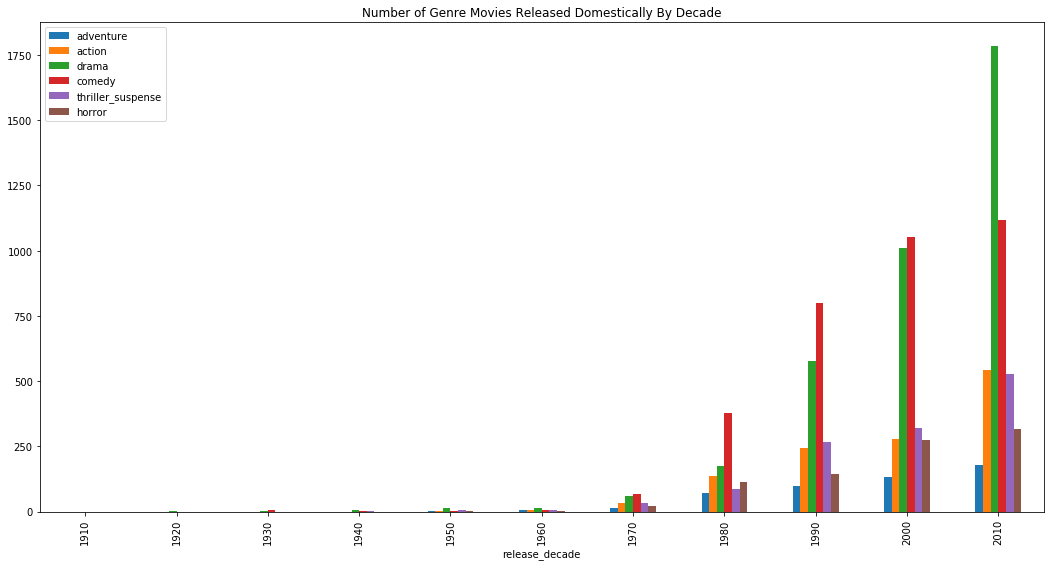

In [7]:
figure, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(18,9))

# Since we are dealing with boolean columns, we must use 'sum' to get the total counts
data.groupby('release_decade').sum().plot.bar(y=['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'], ax=ax1, title='Number of Genre Movies Released Domestically By Decade')

Key Takeaways:
- Drama and Comedy are the two most common genres
- Thriller/Suspense and Action are neck and neck for the next most produced genres
- Adventure is way less common, probably due to its relatively higher budget
- Our dataset has far more movies being released in the last three decades

In [8]:
data['adventure'] = data['genres_mojo'].str.contains('Adventure', na=False) 
data['action'] = data['genres_mojo'].str.contains('Action', na=False)
data['drama'] = data['genres_mojo'].str.contains('Drama', na=False)
data['comedy'] = data['genres_mojo'].str.contains('Comedy', na=False)
data['thriller_suspense'] = data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)
data['horror'] = data['genres_mojo'].str.contains('Horror', na=False)

#### Domestic Gross

In [9]:
# Sort the genres in descending order of mean domestic adjusted gross

# All genres
genres = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']

# Dictionary of genres and their mean domestic adjusted gross
genres_mean_domestic_adj = {genre: round(data[data[genre]]['domestic_adj'].mean() / 1000000, 1) for genre in genres}

# Sorted list of genres in descending order of mean domestic adjusted gross
genres_mean_domestic_adj_sorted = sorted(genres_mean_domestic_adj.items(), key=lambda x: x[1], reverse=True)

print("Mean Adjusted Domestic Gross:\n")
for genre, amount in genres_mean_domestic_adj_sorted:
    print('{0:<20} {1:.1f} million dollars'.format(genre.title(), amount))

Mean Adjusted Domestic Gross:

Adventure            120.0 million dollars
Action               74.4 million dollars
Horror               43.4 million dollars
Comedy               38.7 million dollars
Thriller_Suspense    34.6 million dollars
Drama                21.2 million dollars


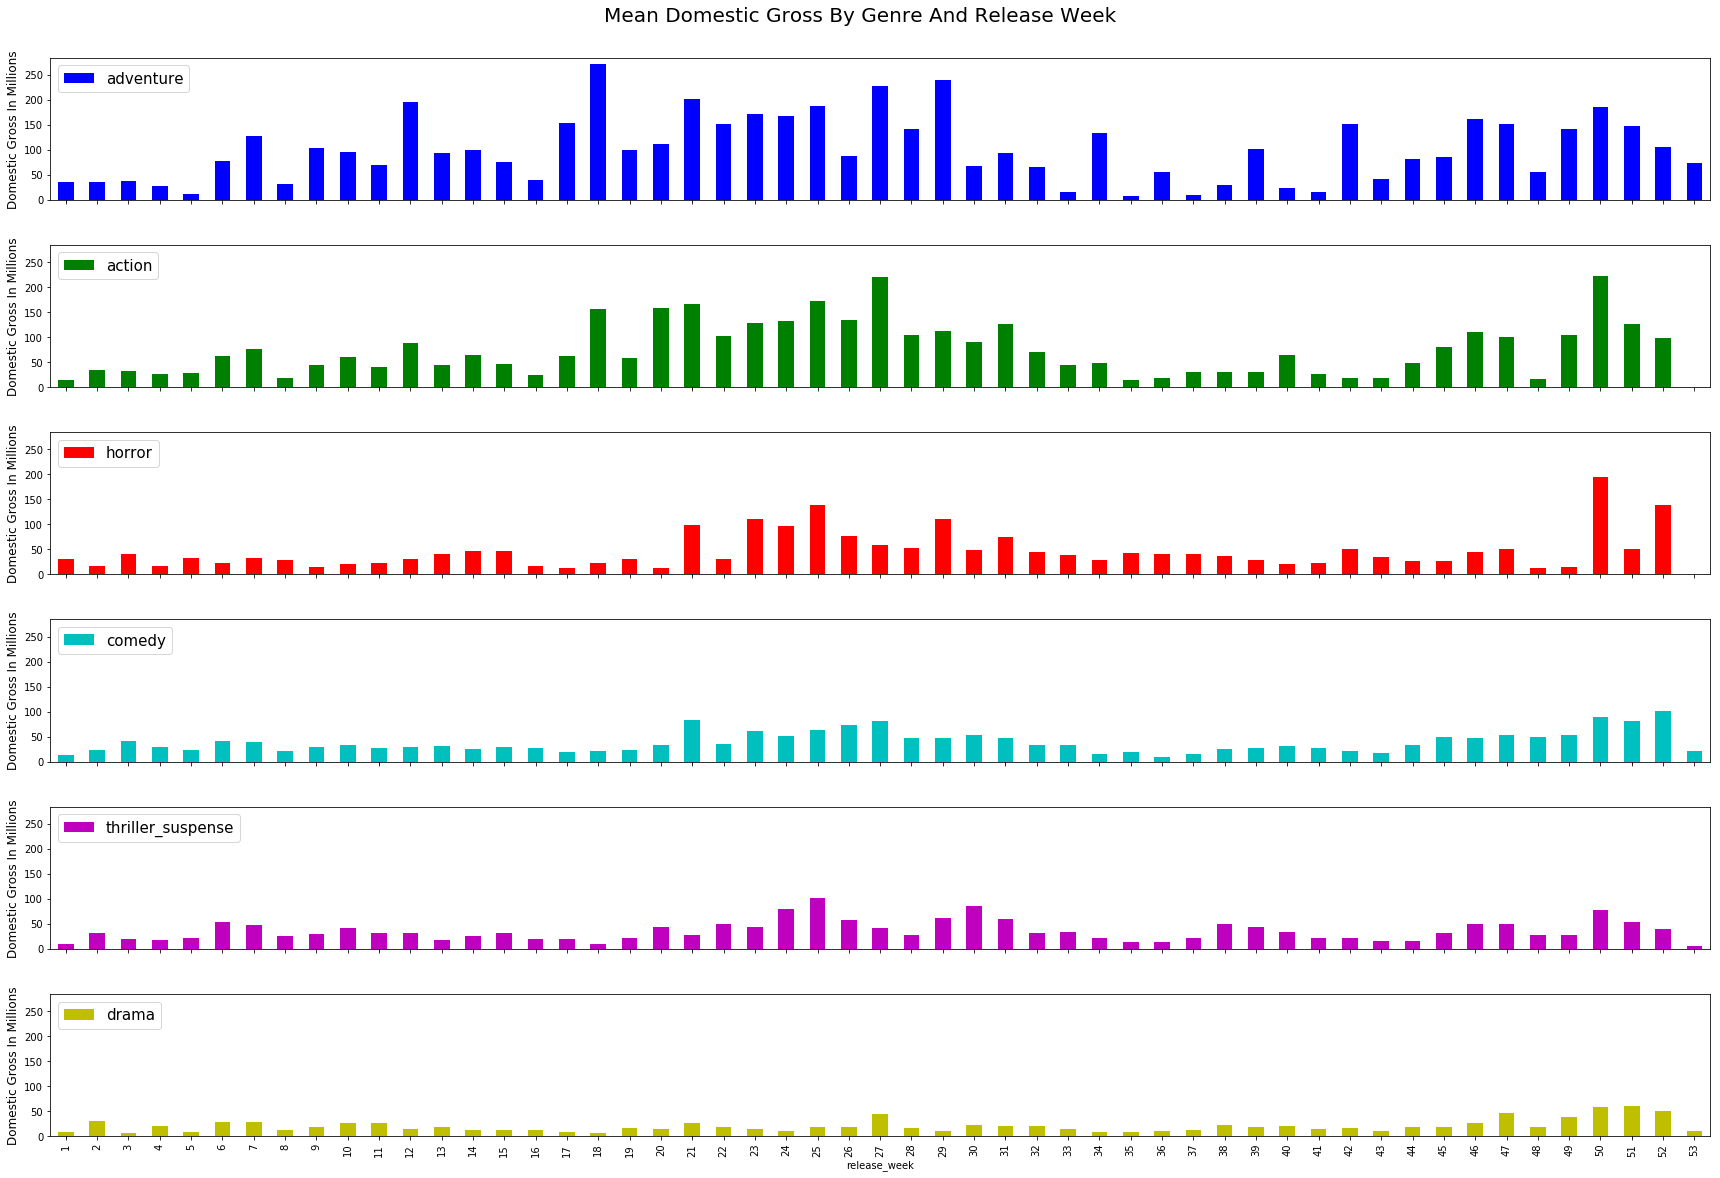

In [10]:
# The order to plot the genres
genres_domestic_gross_order = [k for k,v in genres_mean_domestic_adj_sorted]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Domestic Gross By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres_domestic_gross_order, axes_list, colors):
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(kind='bar', y='domestic_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

Key Takeaways:
- Action and Adventure have the biggest seasonal differences, most noticeably in Summer and at Thanksgiving and Christmas
- All genres except Drama have a bump in Summer
- All genres have a bump at Christmastime

#### Production Budget

In [11]:
# Sort the genres in descending order of mean adjusted production budgets

# All genres
genres = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']

# Dictionary of genres and their mean production budgets
genres_mean_budgets_adj = {genre: round(data[data[genre]]['budget_adj'].mean() / 1000000, 1) for genre in genres}

# Sorted list of genres in descending order of mean domestic adjusted gross
genres_mean_budgets_adj_sorted = sorted(genres_mean_budgets_adj.items(), key=lambda x: x[1], reverse=True)

print("Mean Adjusted Budget:\n")
for genre, amount in genres_mean_budgets_adj_sorted:
    print('{0:<20} {1:.1f} million dollars'.format(genre.title(), amount))

Mean Adjusted Budget:

Adventure            109.5 million dollars
Action               83.5 million dollars
Thriller_Suspense    43.4 million dollars
Comedy               36.2 million dollars
Horror               31.4 million dollars
Drama                29.5 million dollars


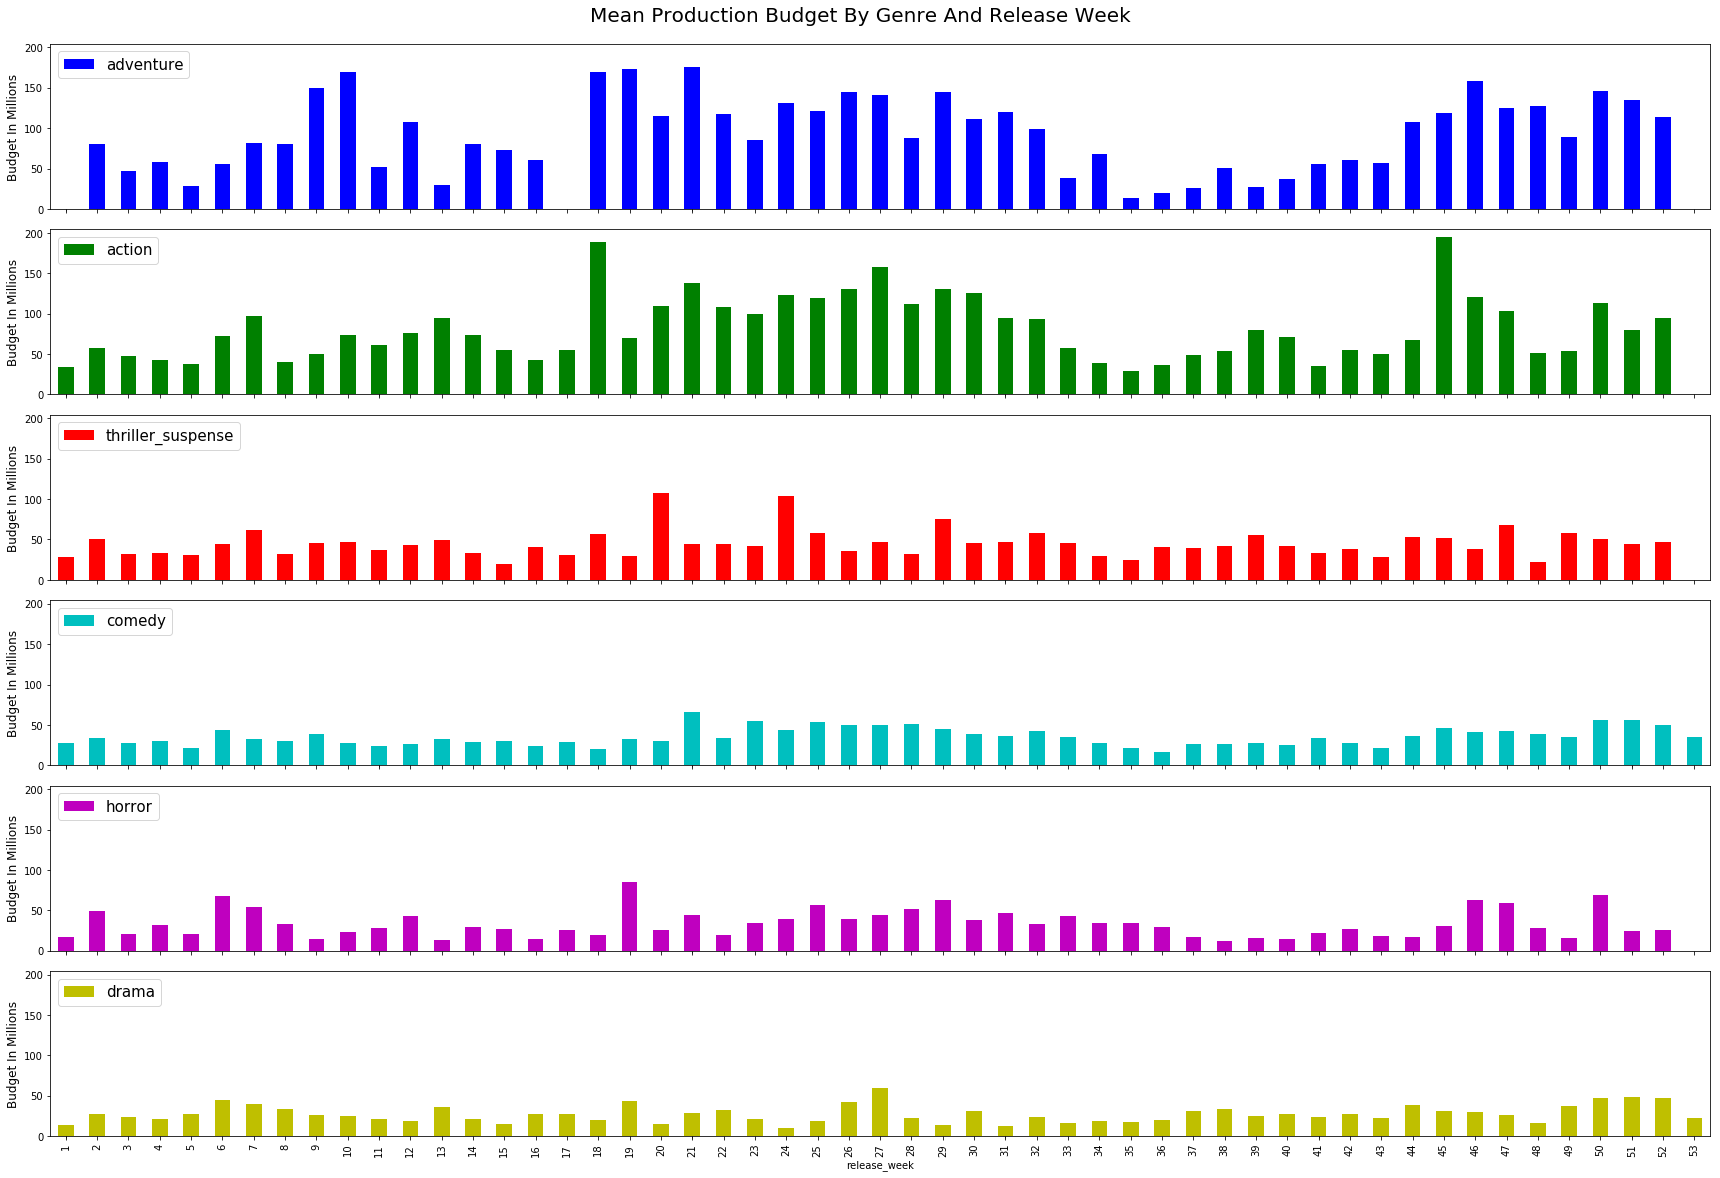

In [12]:
# The order to plot the genres
genres_budgets_order = [k for k,v in genres_mean_budgets_adj_sorted]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Production Budget By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

genres = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for genre, axis, color in zip(genres_budgets_order, axes_list, colors):
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(kind='bar', y='budget_adj', xticks=range(1, 54), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Budget In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)

plt.tight_layout() 

Key Takeaways:
- Action and Adventure have much larger budgets in general
- Thriller/Suspense seems to have the third largest mean budget
- Drama, Comedy, and Horror all have approximately the same mean budget

### Analyze By Decade

#### Domestic Gross

In [13]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html
def autolabel(axis):
    """
    Attach a text label above each bar displaying its height
    """
    for i in axis.patches:
        height = i.get_height()
        axis.text(i.get_x() + i.get_width()/2, 1.05*height, '%d' % int(height), ha='center', va='bottom')

In [14]:
# Tailored from matplotlib documentation
# https://matplotlib.org/examples/api/barchart_demo.html
# Customized for adding the counts when a percentage height is used instead of the count
# Must send in an array of the corresponding counts for each bar
def autolabel_with_count(axis, counts):
    """
    Attach a text label above each bar displaying its count
    """
    for i, val in enumerate(axis.patches):
        height = counts[i]
        axis.text(val.get_x() + val.get_width()/2, val.get_height()*1.05, '%d' % int(height), ha='center', va='bottom')

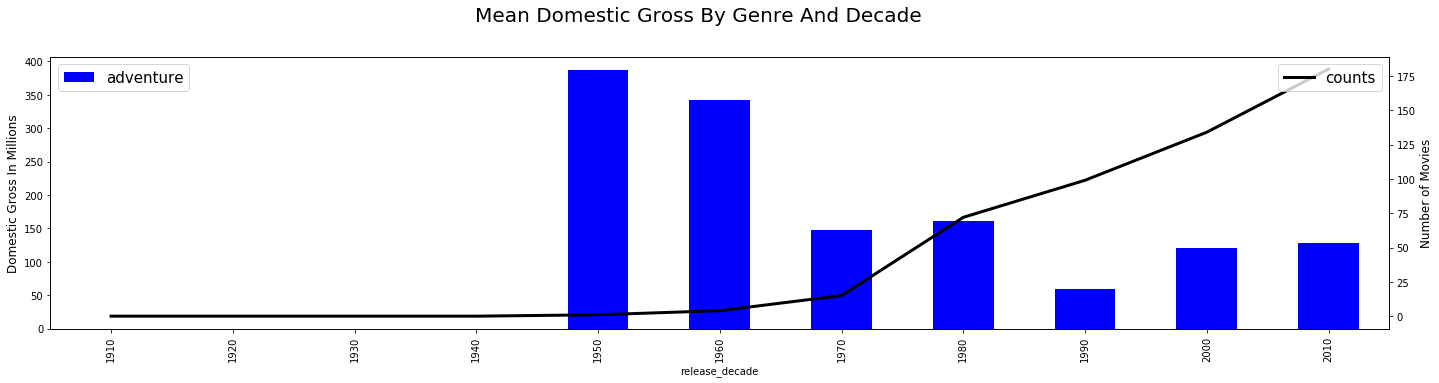

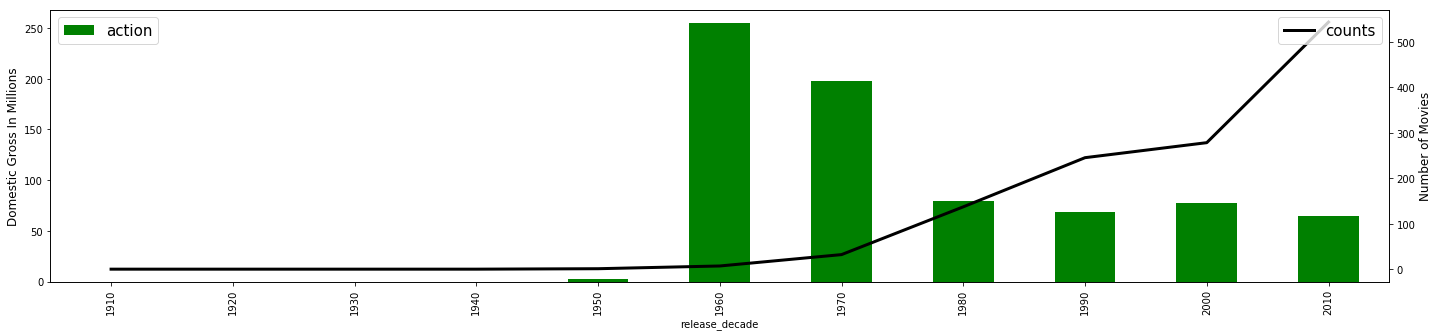

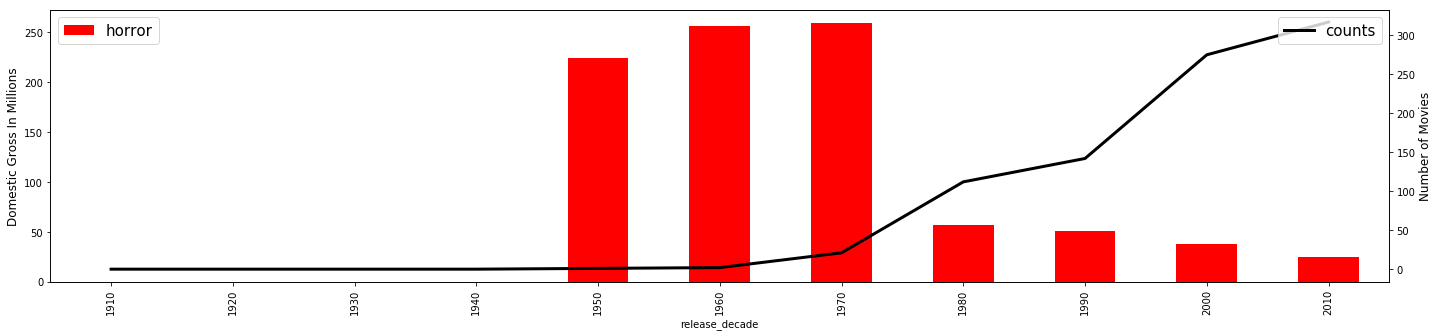

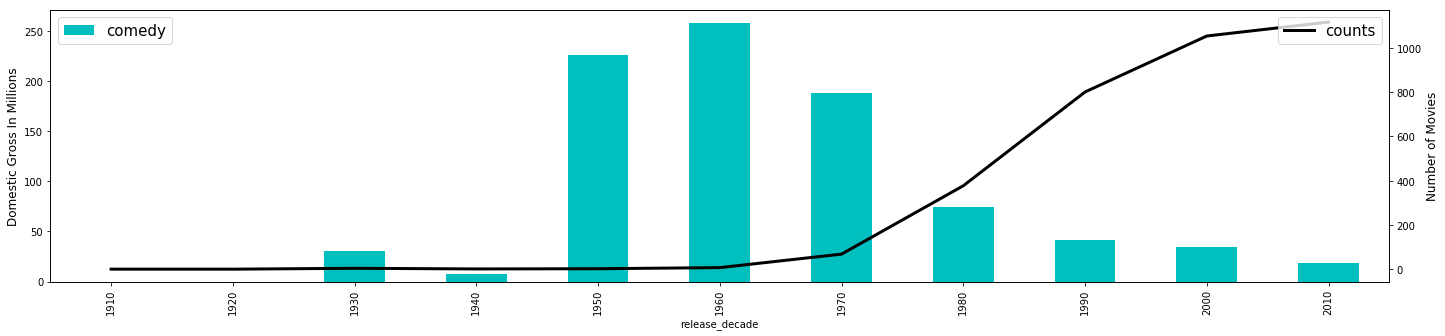

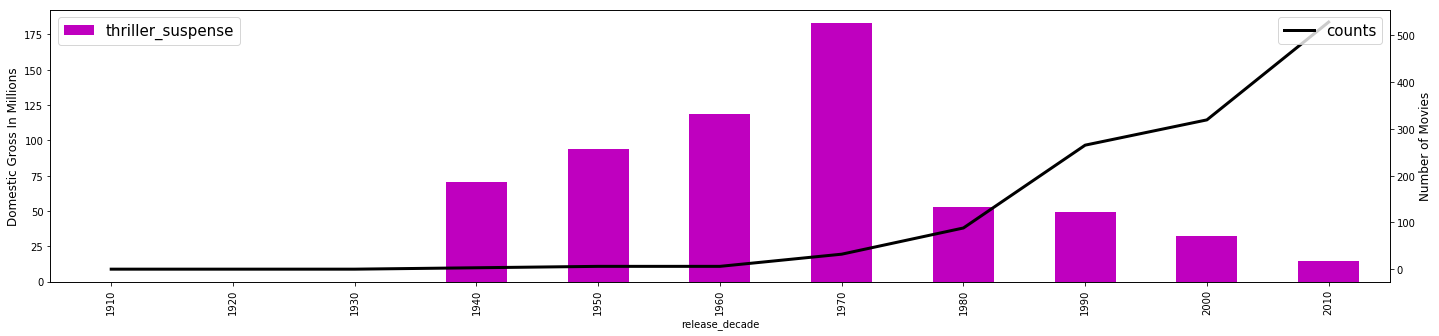

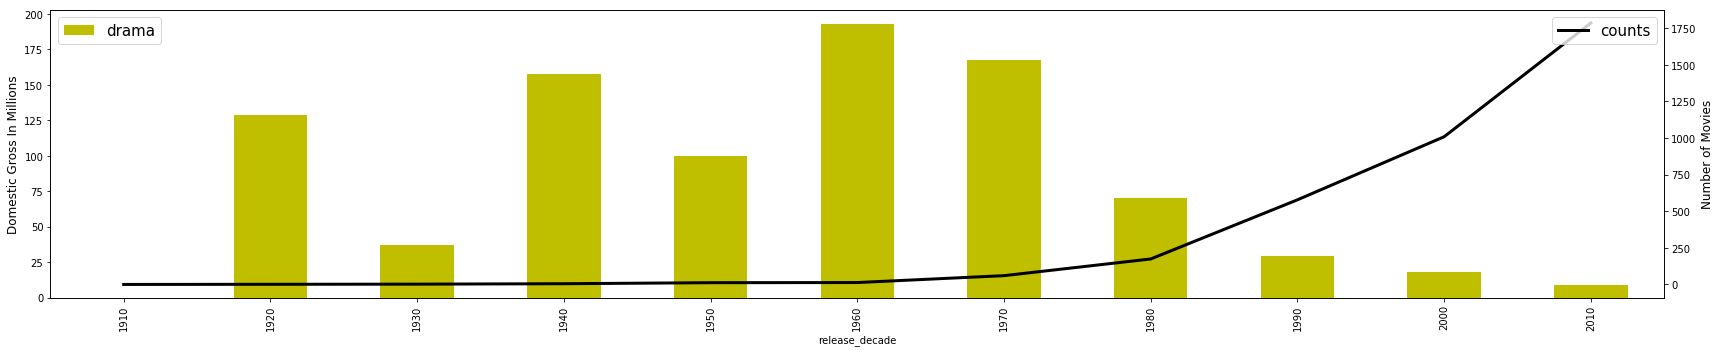

In [15]:
# Create variables for first_axes, secondary_axes, and counter variables 
ax1, ax2, ax3, ax4, ax5, ax6 = 'abcdef'
first_axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1 = 'abcdef'
second_axes_list = [ax1_1, ax2_1, ax3_1, ax4_1, ax5_1, ax6_1]

# Counters to keep track of iteration
counters = [0, 1, 2, 3, 4, 5]

for genre, first_axis, second_axis, color, count in zip(genres_domestic_gross_order, first_axes_list, second_axes_list, colors, counters):
        figure, first_axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 5))
        second_axis = figure.add_axes()

        # Only write the title once
        if count == 0:
            figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)

        grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
        grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
        
        # Set up y-axis    
        first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        first_axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
        first_axis.legend([genre], loc=2, fontsize=15)
        
        # Set up second y-axis
        second_axis = first_axis.twinx()
        second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel('Number of Movies', fontsize=12)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        # Only show graphs when on the last one
        if count == len(counters) - 1:
            plt.tight_layout()

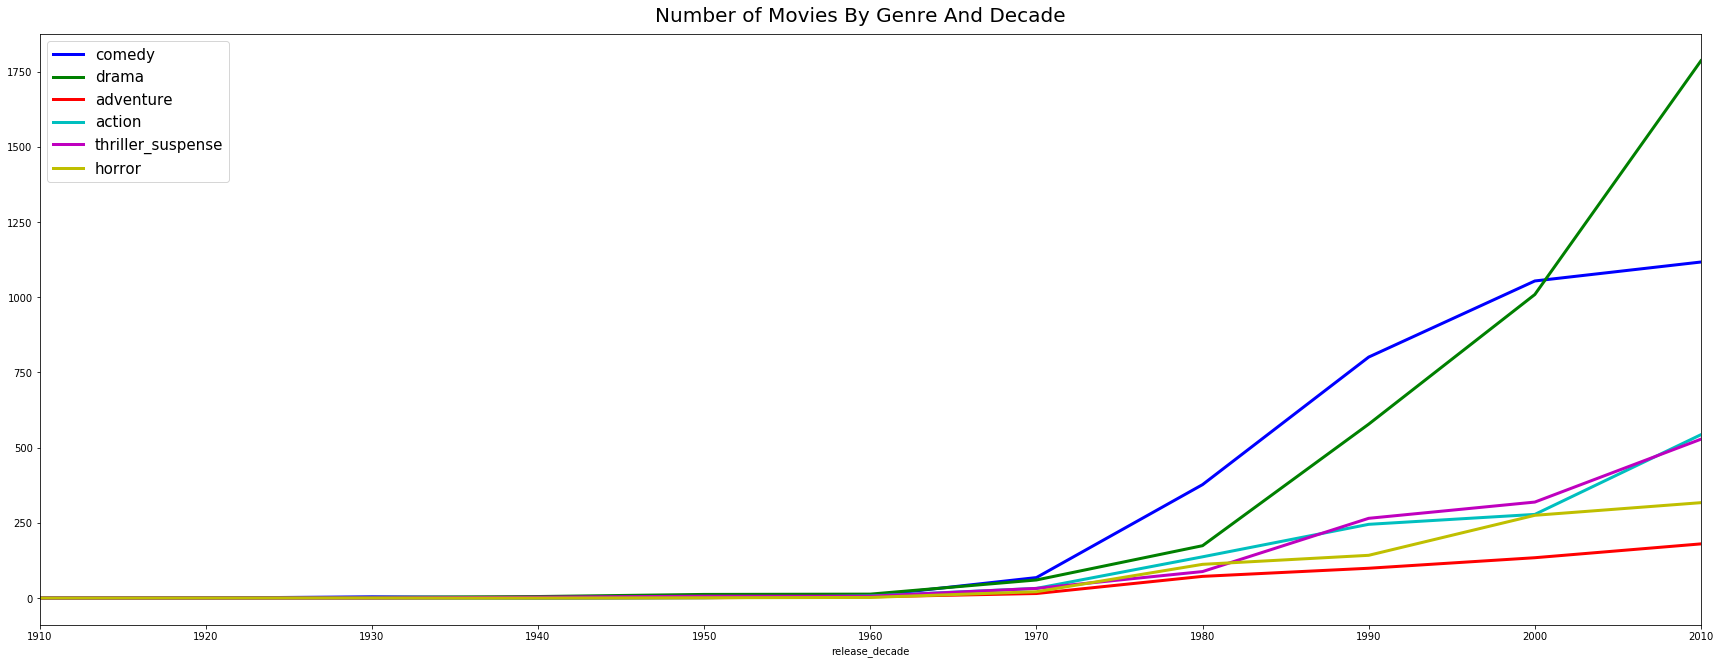

In [22]:
figure, axis = plt.subplots(1, 1, figsize=(24, 9))
figure.suptitle('Number of Movies By Genre And Decade', fontsize=20, y=1.02)

com = comedy.groupby('release_decade')['domestic_adj'].count()
dra = drama.groupby('release_decade')['domestic_adj'].count()
adv = adventure.groupby('release_decade')['domestic_adj'].count()
act = action.groupby('release_decade')['domestic_adj'].count()
thr = thriller_suspense.groupby('release_decade')['domestic_adj'].count()
hor = horror.groupby('release_decade')['domestic_adj'].count()

genres_groups = [com, dra, adv, act, thr, hor]

for decade in range(1910, 2020, 10):
    for genre in genres_groups:  
        if decade not in genre.index:
            #grp.loc[decade] = 0
            genre.loc[decade] = 0
            genre.sort_index(ascending=True, inplace=True)
            
for genre, color in zip(genres_groups, colors):
    genre.plot(kind='line', xticks=range(1910, 2020, 10), linewidth=3, color=color)
    
axis.legend(['comedy', 'drama', 'adventure', 'action', 'thriller_suspense', 'horror'], fontsize=15)
plt.tight_layout()

Key Takeaways:
- The 1970s seems like the best decade for the average movie in terms of domestic box office gross. Every genre had its most- or second-most profitable decade then.
- The average domestic return of movies in all genres has declined significantly in the past four decades
- This is probably due to the sheer number of movies releasd these days. A few big winners can't boost the average for the many losers.

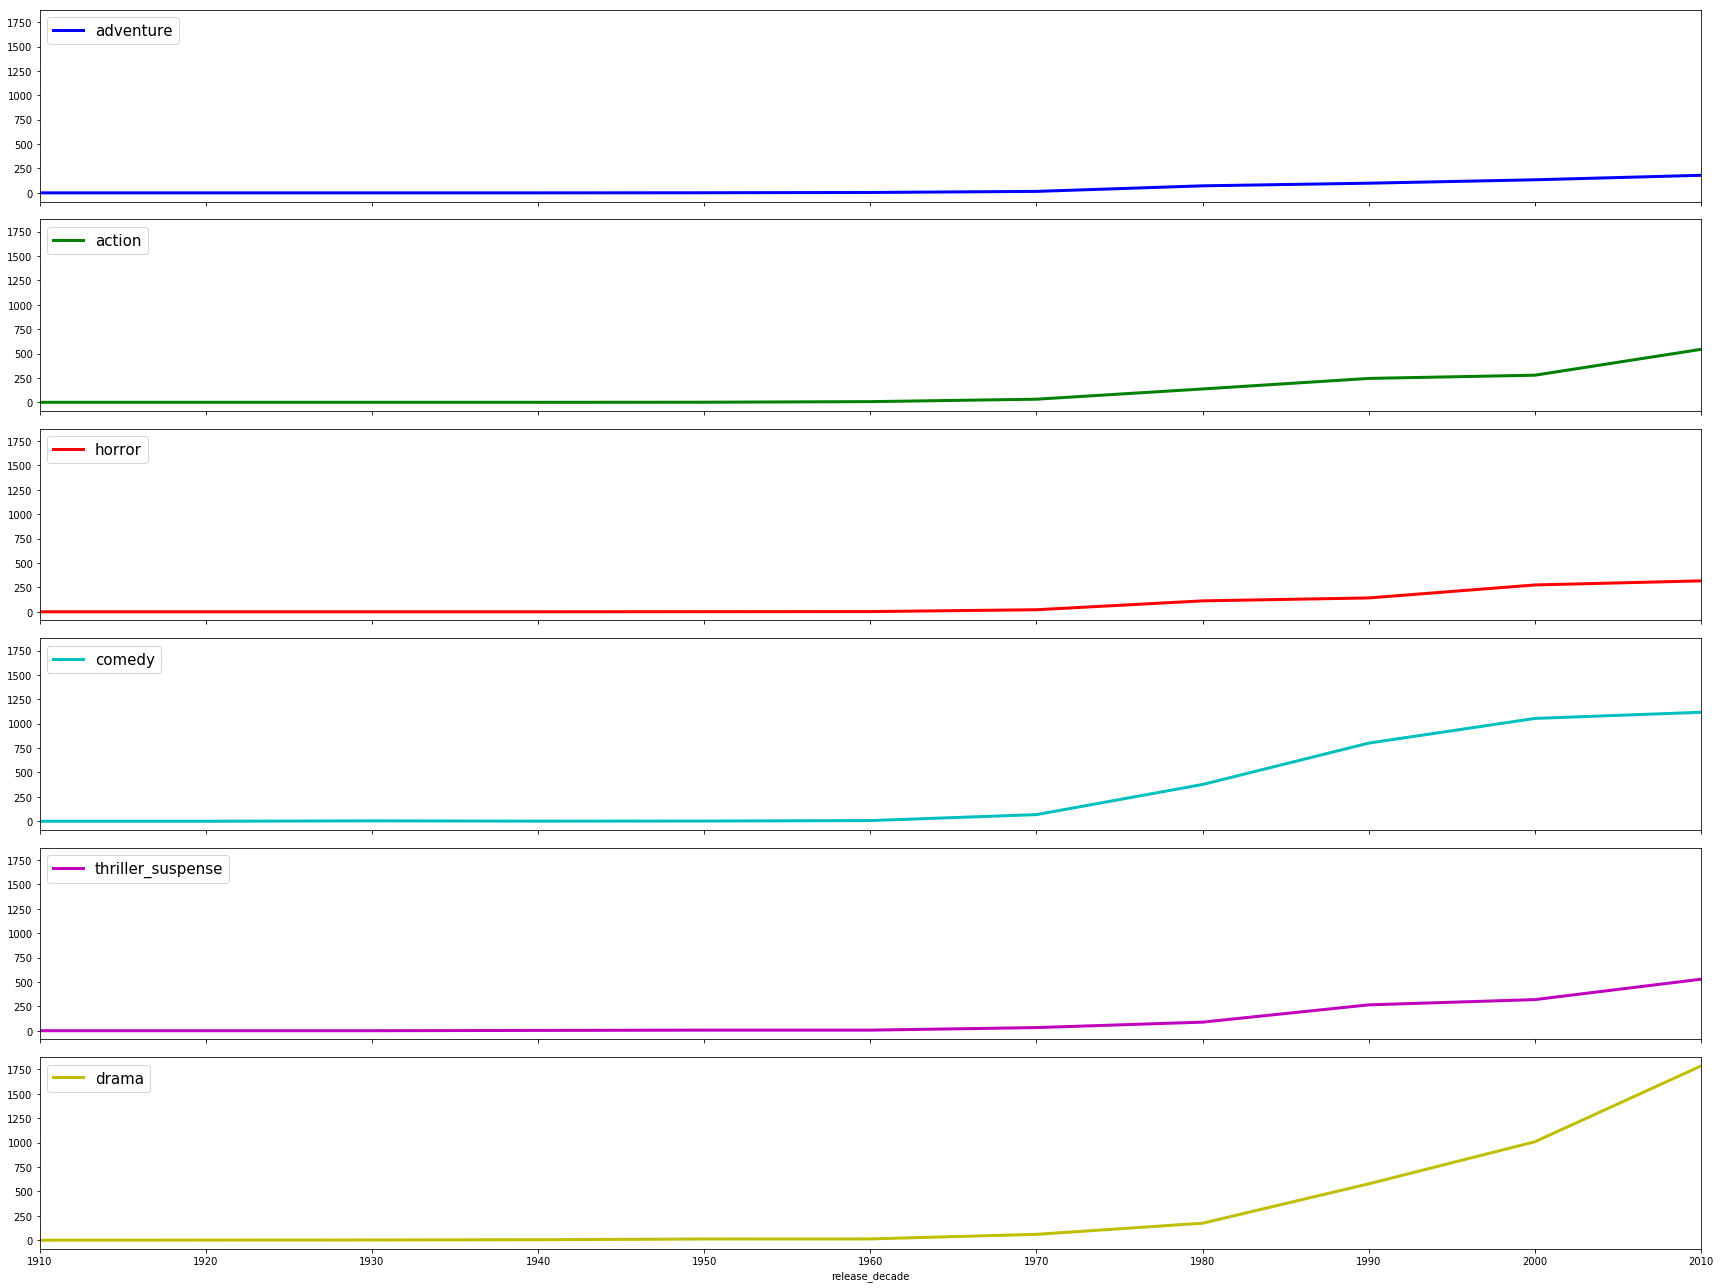

In [24]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24,18))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres_domestic_gross_order, axes_list, colors):
    grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp_counts.index:
            #grp.loc[decade] = 0
            grp_counts.loc[decade] = 0

    # Sort the series by its index to have the decades in chronological order                
    #grp.sort_index(ascending=True, inplace=True)
    grp_counts.sort_index(ascending=True, inplace=True)

    grp_counts.plot(kind='line', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.legend([genre], loc=2, fontsize=15)
    
plt.tight_layout()

Key Takeaways:
- Increasingly, more movies are made in every genre in every decade.
- Comedy and Drama in particular have had an explosion in numbers in the last few decades.

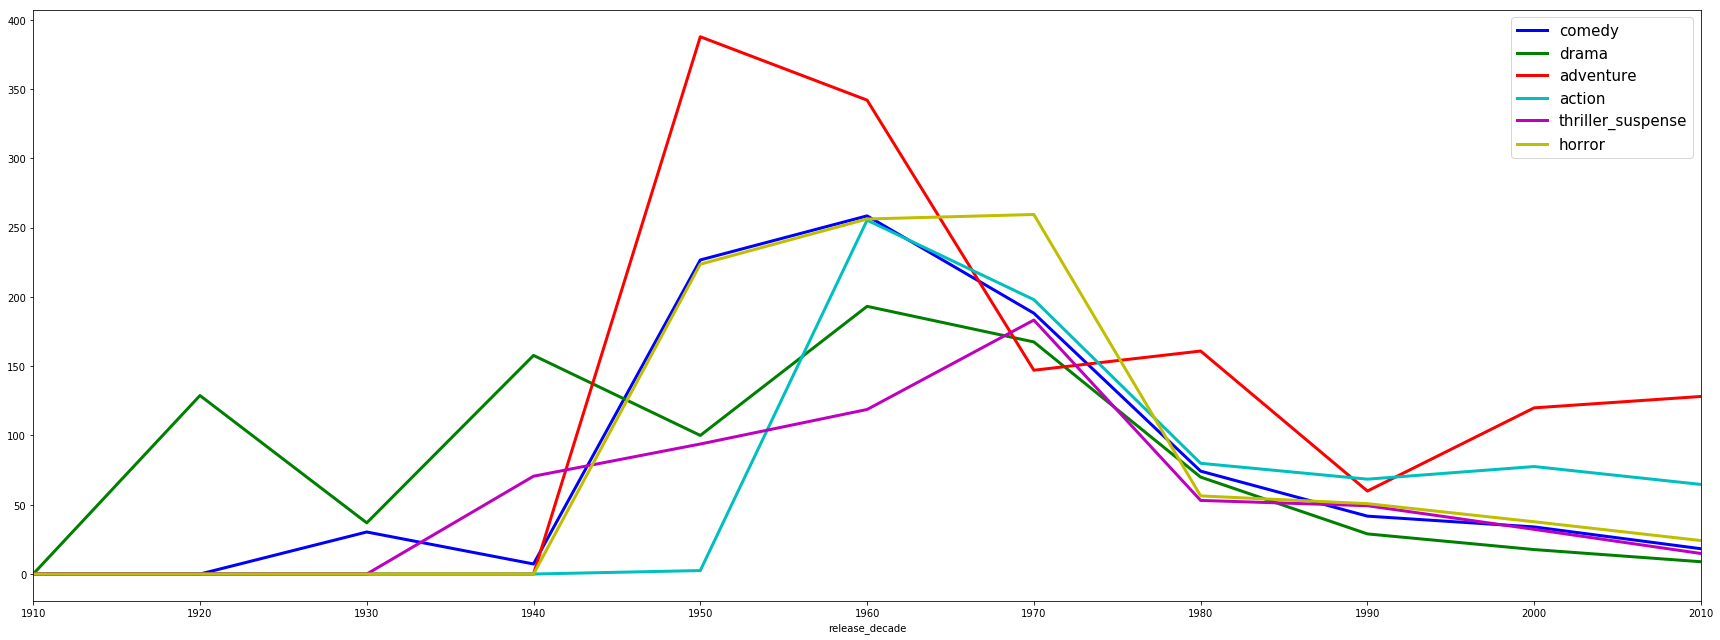

In [20]:
figure, axis = plt.subplots(1, 1, figsize=(24, 9))

com = (comedy.groupby('release_decade').mean() / 1000000)['domestic_adj']
dra = (drama.groupby('release_decade').mean() / 1000000)['domestic_adj']
adv = (adventure.groupby('release_decade').mean() / 1000000)['domestic_adj']
act = (action.groupby('release_decade').mean() / 1000000)['domestic_adj']
thr = (thriller_suspense.groupby('release_decade').mean() / 1000000)['domestic_adj']
hor = (horror.groupby('release_decade').mean() / 1000000)['domestic_adj']

genres_groups = [com, dra, adv, act, thr, hor]

for decade in range(1910, 2020, 10):
    for genre in genres_groups:  
        if decade not in genre.index:
            #grp.loc[decade] = 0
            genre.loc[decade] = 0
            genre.sort_index(ascending=True, inplace=True)
            
for genre, color in zip(genres_groups, colors):
    genre.plot(kind='line', xticks=range(1910, 2020, 10), linewidth=3, color=color)
    
axis.legend(['comedy', 'drama', 'adventure', 'action', 'thriller_suspense', 'horror'], fontsize=15)
plt.tight_layout()

In [ ]:
(week['domestic_breakeven'].sum() / week['domestic_breakeven'].count() * 100).plot(xticks=range(1,54), figsize=(18,9), ax=ax1, title='Breakeven By Release Week')
ax1.set_ylabel('Percentage of Movies That Breakeven')
ax1.axhline((data['domestic_breakeven'].sum() / data['domestic_breakeven'].count() * 100).mean(), color='k', linestyle='--')

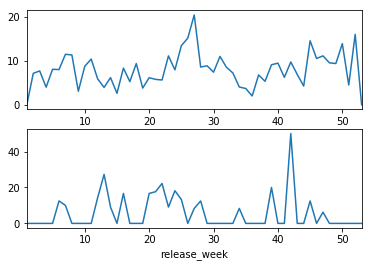

In [38]:
figure, (axis1, axis2) = plt.subplots(2, 1) 
grp_c = data[data['comedy']].groupby('release_week')['domestic_breakeven'].sum() / data[data['comedy']].groupby('release_week')['domestic_breakeven'].count() * 100
grp_a = data[data['adventure']].groupby('release_week')['domestic_breakeven'].sum() / data[data['adventure']].groupby('release_week')['domestic_breakeven'].count() * 100
grp_c.plot(ax=axis1)
grp_a.plot(ax=axis2)

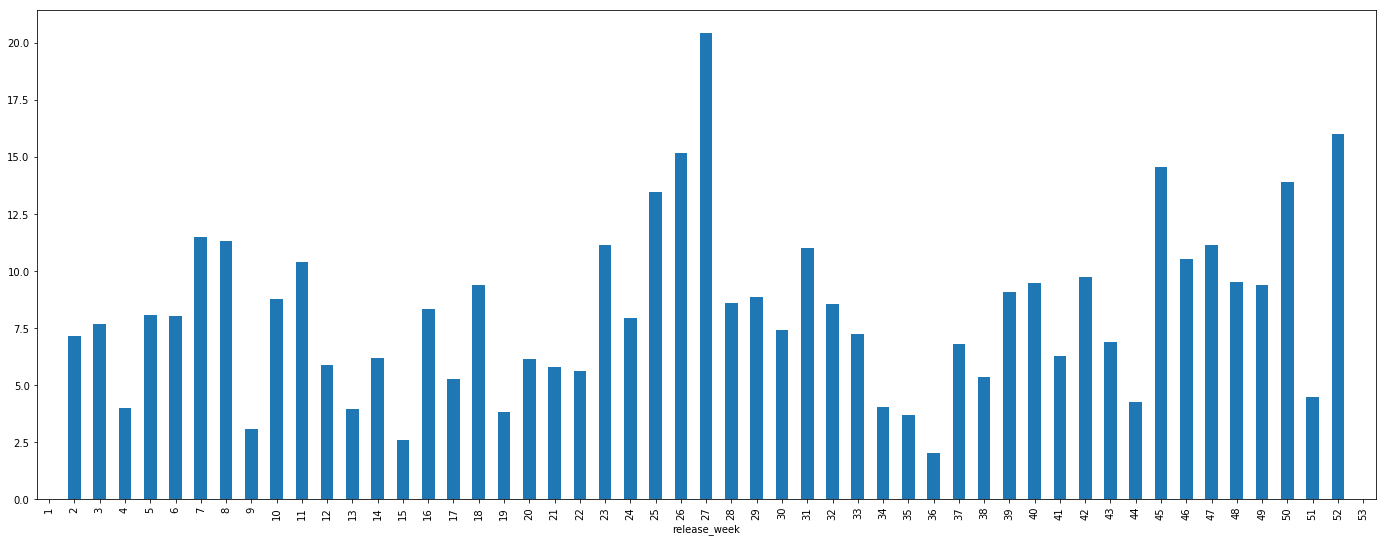

In [32]:
grp = data[data['comedy']].groupby('release_week')['domestic_breakeven'].sum() / data[data['comedy']].groupby('release_week')['domestic_breakeven'].count() * 100
grp.plot(kind='bar', figsize=(24,9))

In [37]:
grp = data.groupby('release_week')['domestic_breakeven'].sum() / data.groupby('release_week')['domestic_breakeven'].count() * 100
grp

release_week
1      9.615385
2      4.761905
3      5.802048
4      2.671756
5      6.600660
6      8.000000
7      6.918239
8      7.636364
9      4.046243
10     5.263158
11     6.017192
12     5.830904
13     5.163043
14     5.691057
15     4.533333
16     2.865330
17     3.000000
18     3.305785
19     4.098361
20     5.263158
21     8.480565
22     5.940594
23     6.730769
24     7.736390
25     7.371795
26     9.523810
27    10.931174
28     7.902736
29     7.836991
30     4.848485
31     7.988166
32     8.831909
33     5.494505
34     4.187192
35     4.819277
36     1.801802
37     4.186047
38     4.925054
39     5.048077
40     6.436782
41     4.728132
42     6.976744
43     6.142506
44     5.588235
45     6.544503
46     5.932203
47     8.917197
48     5.415162
49     4.901961
50     7.964602
51     9.785203
52     8.865248
53    10.000000
Name: domestic_breakeven, dtype: float64

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres_domestic_gross_order, axes_list, colors):
    # We must replace missing decades with zeroes to have the bar plots xticks line up
    
    # Create a series with decades as indexes and domestic gross as values
    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
    grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
            grp_counts.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
    grp_counts.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of each genre made per decade above each bar
    autolabel_with_count(axis, grp_counts.values)

plt.tight_layout() 

In [ ]:
# Figure and axes creation
figure, first_axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 18))
second_axis = figure.add_axes()
figure.suptitle('Mean Domestic Gross Of Comedies By Decade', fontsize=20, y=1.02)

# Data creation
grp = (data[data['comedy']].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
grp_counts = data[data['comedy']].groupby('release_decade')['domestic_adj'].count().copy()

# If the series is missing a decade, add it as an index and set the value to zero
for decade in range(1910, 2020, 10):
    if decade not in grp.index:
        grp.loc[decade] = 0
        grp_counts.loc[decade] = 0

# Sort the series by its index to have the decades in chronological order                
grp.sort_index(ascending=True, inplace=True)
grp_counts.sort_index(ascending=True, inplace=True)

# Set up axis1 graph
first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color='b')
first_axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
first_axis.legend(['comedy'], loc=2, fontsize=15)

second_axis = first_axis.twinx()

# Set up axis2 graph
second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
second_axis.set_ylabel('Number of Movies', fontsize=12)
second_axis.legend(['count'], loc=1, fontsize=15)

plt.tight_layout()

In [ ]:
#bar_and_line_chart(
#    grouped_series_data = (data[data['comedy']].groupby('release_decade').mean() / 1000000)['domestic_adj'],
#    grouped_series_count_data=data[data['comedy']].groupby('release_decade')['domestic_adj'].count(),
#    figsize=(24,5),
#    color='b',
#    figtitle='Mean Domestic Gross By Genre And Decade',
#    axis1_ylabel='Domestic Gross In Millions',
#    axis1_legend_text='comedy',
#    axis2_ylabel='Number of Movies',
#    axis2_legend_text='counts')

In [ ]:
figure, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(24, 16))
figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)

grp = (data[data['comedy']].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
grp_counts = data[data['comedy']].groupby('release_decade')['domestic_adj'].count().copy()
    
# If the series is missing a decade, add it as an index and set the value to zero
for decade in range(1910, 2020, 10):
    if decade not in grp.index:
        grp.loc[decade] = 0
        grp_counts.loc[decade] = 0
    
# Sort the series by its index to have the decades in chronological order                
grp.sort_index(ascending=True, inplace=True)
grp_counts.sort_index(ascending=True, inplace=True)

    # Put the count of each genre made per decade above each bar
    #autolabel_with_count(ax1, grp_counts.values)
    
ax1 = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3)
ax1.set_ylabel('Domestic Gross In Millions', fontsize=12)
ax1.legend(['comedy'], loc=2, fontsize=15)

ax2 = ax1.twinx()
    
ax2.plot(ax1.get_xticks(), grp_counts.values, linewidth=3, color='k')
ax2.set_ylabel('Number of Movies', fontsize=12)
ax2.legend(['counts'], loc=1, fontsize=15)

plt.tight_layout()

In [ ]:
def bar_and_line_chart(
    grouped_series_data,
    grouped_series_count_data,
    figsize, color,
    figtitle,
    axis1_ylabel,
    axis1_legend_text,
    axis2_ylabel,
    axis2_legend_text
):
    # Figure and axes creation
    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    second_axis = figure.add_axes()
    figure.suptitle(figtitle, fontsize=20, y=1.02)
    
    # Data creation
    grp = grouped_series_data.copy()
    grp_counts = grouped_series_count_data.copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
            grp_counts.loc[decade] = 0
            
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
    grp_counts.sort_index(ascending=True, inplace=True)
    
    # Set up axis1 graph
    axis1 = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
    axis1.set_ylabel(axis1_ylabel, fontsize=12)
    axis1.legend([axis1_legend_text], loc=2, fontsize=15)

    axis2 = axis1.twinx()
    
    # Set up axis2 graph
    axis2.plot(axis1.get_xticks(), grp_counts.values, linewidth=3, color='k')
    axis2.set_ylabel(axis2_ylabel, fontsize=12)
    axis2.legend([axis2_legend_text], loc=1, fontsize=15)
    
    plt.tight_layout()

In [ ]:
def multiple_bar_and_line_charts(
    groupby_data_needs_separator,
    groupby_data_for_counts_needs_separator,
    data_separator_list,
    first_axes_list,
    second_axes_list,
    colors_list,
    counter_list,
    figtitle,
    figsize, 
    axis1_ylabel,
    axis2_ylabel,
):
    for separator, first_axis, second_axis, color, count in zip(data_separator_list, first_axes_list, second_axes_list, colors_list, counter_list):
        figure, axis = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        second_axis = figure.add_axes()

        if count == 0:
            figure.suptitle(figtitle, fontsize=20, y=1.02)

        grp = groupby_data_needs_separator.copy()
        grp_counts = groupby_data_for_counts_needs_separator.copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
    
        first_axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        first_axis.set_ylabel(axis1_ylabel, fontsize=12)
        first_axis.legend([separator], loc=2, fontsize=15)

        second_axis = first_axis.twinx()

        second_axis.plot(first_axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel(axis2_ylabel, fontsize=12)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        if count == len(counter) - 1:
            plt.tight_layout()

In [ ]:
def multiple_bar_and_line_charts(
    groupby_data_needs_separator,
    groupby_data_for_counts_needs_separator,
    data_separator_list,
    first_axes_list,
    second_axes_list,
    colors_list,
    counter_list,
    figtitle,
    figsize, 
    axis1_legend_text,
    axis2_legend_text
    genres_list,
    first_axes_list,
    second_axes_list,
):
    for separator, first_axis, second_axis, color, count in zip(data_separator_list, first_axes_list, second_axes_list, colors_list, counter_list):
        figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 5))
        second_axis = figure.add_axes()

        if count == 0:
            figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)

        grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
        grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
    
        # If the series is missing a decade, add it as an index and set the value to zero
        for decade in range(1910, 2020, 10):
            if decade not in grp.index:
                grp.loc[decade] = 0
                grp_counts.loc[decade] = 0

        # Sort the series by its index to have the decades in chronological order                
        grp.sort_index(ascending=True, inplace=True)
        grp_counts.sort_index(ascending=True, inplace=True)
    
        axis = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
        axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
        axis.legend([genre], loc=2, fontsize=15)

        second_axis = axis.twinx()

        second_axis.plot(axis.get_xticks(), grp_counts.values, linewidth=3, color='k')
        second_axis.set_ylabel('Number of Movies', fontsize=12)
        second_axis.legend(['counts'], loc=1, fontsize=15)
        
        if count == len(counter) - 1:
            plt.tight_layout()

In [ ]:
#def bar_and_line_chart(axis1, second_axis, genre, color):
#    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
#    grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
#    
#    # If the series is missing a decade, add it as an index and set the value to zero
#    for decade in range(1910, 2020, 10):
#        if decade not in grp.index:
#            grp.loc[decade] = 0
#            grp_counts.loc[decade] = 0
#            
#    # Sort the series by its index to have the decades in chronological order                
#    grp.sort_index(ascending=True, inplace=True)
#    grp_counts.sort_index(ascending=True, inplace=True)
#    
#    axis1 = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
#    axis1.set_ylabel('Domestic Gross In Millions', fontsize=12)
#    axis1.legend([genre], loc=2, fontsize=15)

#    axis2 = axis1.twinx()

#    axis2.plot(axis1.get_xticks(), grp_counts.values, linewidth=3, color='k')
#    axis2.set_ylabel('Number of Movies', fontsize=12)
#    axis2.legend(['counts'], loc=1, fontsize=15)
    

In [ ]:
#def bar_and_line_chart(grouped_series_data, grouped_series_count_data, figsize, color, figtitle, legend_text, axis1_ylabel, axis2_ylabel):
#    # Figure and axes creation
#    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=(24, 5))
#    second_axis = figure.add_axes()
#    figure.suptitle('Mean Domestic Gross By Genre And Decade', fontsize=20, y=1.02)
#    
#    # Data creation
#    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['domestic_adj'].copy()
#    grp_counts = data[data[genre]].groupby('release_decade')['domestic_adj'].count().copy()
#    
#    # If the series is missing a decade, add it as an index and set the value to zero
#    for decade in range(1910, 2020, 10):
#        if decade not in grp.index:
#            grp.loc[decade] = 0
#            grp_counts.loc[decade] = 0
#            
#    # Sort the series by its index to have the decades in chronological order                
#    grp.sort_index(ascending=True, inplace=True)
#    grp_counts.sort_index(ascending=True, inplace=True)
#    
#    # Set up axis1 graph
#    axis1 = grp.plot(kind='bar', xticks=range(1910, 2020, 10), linewidth=3, color=color)
#    axis1.set_ylabel('Domestic Gross In Millions', fontsize=12)
#    axis1.legend([genre], loc=2, fontsize=15)

#    axis2 = axis1.twinx()
#    
#    # Set up axis2 graph
#    axis2.plot(axis1.get_xticks(), grp_counts.values, linewidth=3, color='k')
#    axis2.set_ylabel('Number of Movies', fontsize=12)
#    axis2.legend(['counts'], loc=1, fontsize=15)
#    
#    plt.tight_layout()

#### Production Budget

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Mean Production Budget By Genre And Release Week', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres_budgets_order, axes_list, colors):
    # We must replace missing decades with zeroes to have the bar plots xticks line up
    
    # Create a series with decades as indexes and domestic gross as values
    grp = (data[data[genre]].groupby('release_decade').mean() / 1000000)['budget_adj'].copy()
    
    # If the series is missing a decade, add it as an index and set the value to zero
    for decade in range(1910, 2020, 10):
        if decade not in grp.index:
            grp.loc[decade] = 0
    
    # Sort the series by its index to have the decades in chronological order                
    grp.sort_index(ascending=True, inplace=True)
        
    grp.plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Domestic Gross In Millions', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    autolabel(axis)

plt.tight_layout() 

Key Takeaways:
- Production budgets for Action and Adventure have been increasing since the 1980s
- Production budgets for all other genres have declined since the 1980s
- This is probably due to the heavy use of expensive CGI in Action and Adventure movies, which has only increased over time. Meanwhile, technological advancements have decreased the overall cost of producing movies in general.

### Analyze By Breakeven

In [ ]:
figure, axes = plt.subplots(nrows=6, ncols=1, sharex=True, sharey=True, figsize=(24, 16))
figure.suptitle('Percentage of Movies That Breakeven By Decade', fontsize=20, y=1.02)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

for genre, axis, color in zip(genres_budgets_order, axes_list, colors):
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_decade')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_decade')['domestic_breakeven'].sum().copy()

    # If the series is missing a decade, add it as an index
    # Then set the count to 1 and the sum to 0
    # This avoids division by zero problems when calculating the percentages
    for decade in range(1910, 2020, 10):
        if decade not in grp_count.index:
            grp_count.loc[decade] = 0
            grp_sum.loc[decade] = 0

    # Sort the series by their index to have the decades in chronological order                
    grp_count.sort_index(ascending=True, inplace=True)
    grp_sum.sort_index(ascending=True, inplace=True)

    (grp_sum / grp_count * 100).plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
    axis.set_ylabel('Percentage', fontsize=12)
    axis.legend([genre], loc=2, fontsize=15)
    
    # Put the count of how many movies breakeven above each bar
    autolabel_with_count(axis, grp_count.values)
    
plt.tight_layout() 

In [ ]:
for genre in genres_budgets_order:
    # Create two series with decades as indexes and count and sum as values
    grp_count = data[data[genre]].groupby('release_decade')['domestic_breakeven'].count().copy()
    grp_sum = data[data[genre]].groupby('release_decade')['domestic_breakeven'].sum().copy()
    
    print(grp_count.values)
    print(type(grp_count.values))
    
    #print(genre, grp_sum / grp_count * 100)
    
#    # We must replace missing decades with zeroes to have the bar plots xticks line up
#    
#    # Create a series with decades as indexes and domestic gross as values
#    grp = (data[data[genre]].groupby('release_decade')['domestic_breakeven'].count().copy()
#    
#    # If the series is missing a decade, add it as an index and set the value to zero
#    for decade in range(1910, 2020, 10):
#        if decade not in grp.index:
#            grp.loc[decade] = 0
#    
#    # Sort the series by its index to have the decades in chronological order                
#    grp.sort_index(ascending=True, inplace=True)
#    
#    #grp = data[data[genre]].groupby('release_decade')
#    (grp['domestic_breakeven'].sum() / grp['domestic_breakeven'].count() * 100).plot(kind='bar', xticks=range(1910, 2020, 10), ax=axis, linewidth=3, color=color)
#    axis.set_ylabel('Percentage', fontsize=12)
#    axis.legend([genre], loc=1, fontsize=15)

#plt.tight_layout() 

In [ ]:
grp = data[data['comedy']].groupby('release_decade')['domestic_breakeven'].count().copy()
grp.index

In [ ]:
# Create a series with decades as indexes and domestic gross as values
grp_count = data[data[genre]].groupby('release_decade')['domestic_breakeven'].count().copy()
grp_sum = data[data[genre]].groupby('release_decade')['domestic_breakeven'].sum().copy()

print(grp_count)
print(grp_sum)

# If the series is missing a decade, add it as an index and set the value to zero
for decade in range(1910, 2020, 10):
    if decade not in grp_count.index:
        grp_count.loc[decade] = 1
        grp_sum.loc[decade] = 0
        
# Sort the series by its index to have the decades in chronological order                
grp_count.sort_index(ascending=True, inplace=True)
grp_sum.sort_index(ascending=True, inplace=True)

(grp_sum / grp_count * 100).plot(kind='bar', xticks=range(1910, 2020, 10))

In [ ]:
figure, ax1 = plt.subplots(1,1)

for genre in [adventure, action, drama, comedy, thriller_suspense, horror]:
    grp = genre.groupby('release_decade')
    (grp['domestic_breakeven'].sum() / grp['domestic_breakeven'].count() * 100).plot(xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Breakeven By Decade and Genre', linewidth=3)
    
ax1.set_ylabel('Percentage of Movies That Breakeven')
ax1.legend(['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'])
plt.tight_layout() 

In [ ]:
names = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']
genres = [adventure, action, drama, comedy, thriller_suspense, horror]

for name, genre in zip(names, genres):
    print('There are {} movies in the {} genre'.format(len(genre), name))

In [ ]:
gb = data.groupby('release_decade')

# Cool way to filter using a groupby
comedy = gb.apply(lambda df: df[df['genres_mojo'].str.contains('Comedy', na=False)])

# Can set a groupby back with `set_index` but you lose the original index values
comedy.set_index('release_decade', inplace=True)
comedy.reset_index(inplace=True)

comedy.head()

In [ ]:
gb = data.groupby('release_decade')

# Cool way to filter using a groupby
comedy = gb.apply(lambda df: df[df['genres_mojo'].str.contains('Comedy', na=False)])

# Another way to reset the index, by dropping the groupby'd column
comedy = comedy.reset_index(drop=True)

comedy.head()

In [ ]:
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)].groupby('release_decade')

comedy.head()

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,9), sharey=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

genres = [adventure, action, drama, comedy, thriller_suspense, horror]
names = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']

for axis, genre, name in zip(axes_list, genres, names):
    genre.groupby('release_decade')['title'].count().plot(kind='bar', ax=axis)
    axis.set_ylabel('Count of Movies By Genre')
    axis.set_title(name)
    autolabel(axis)
        
    #for i in axis.patches:
    #    axis.annotate(str(i.get_height()), (i.get_x(), i.get_height()), fontsize=12)
        
plt.tight_layout()

Key Takeaways:
- The most common movies are drama and comedy. This probably is due in part to their smaller budgets. Although we would expect there to be more horror movies if that was the primary cause.
- More movies of all genres seem to get made as time goes on.

In [ ]:
figure, ax1 = plt.subplots(1, 1)

data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

decades = data.groupby('release_decade')

decades['domestic_breakeven'].count().plot(xticks=range(1910, 2020, 10), figsize=(12,9), title='Breakeven By Decade', ax=ax1)
ax1.set_ylabel('Percentage of Movies That Breakeven')

In [ ]:
comedy.groupby('release_decade')['domestic_breakeven'].sum().head()

In [ ]:
comedy.groupby('release_decade')['domestic_breakeven'].count().head()

In [ ]:
comedy.groupby('release_decade').count().head()

## Analyze By Worldwide

### Import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

### Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

# Only look at movies that made money worldwide
data = data[data['worldwide_adj'].notna() & data['worldwide_adj'] > 0]

data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

In [ ]:
data['genres_mojo'].value_counts(dropna=False)

Since so many movies are categorized with multiple genres, we will include movies in all the genres they are listed as having.

This is to avoid deciding what one genre a movie belongs to.

In [ ]:
adventure = data[data['genres_mojo'].str.contains('Adventure', na=False)] 
action = data[data['genres_mojo'].str.contains('Action', na=False)]
drama = data[data['genres_mojo'].str.contains('Drama', na=False)]
comedy = data[data['genres_mojo'].str.contains('Comedy', na=False)]
thriller_suspense = data[data['genres_mojo'].str.contains('Thriller|Suspense', na=False, regex=True)]
horror = data[data['genres_mojo'].str.contains('Horror', na=False)]

In [ ]:
print('adventure has ', len(adventure), 'movies')
print('action has ', len(action), 'movies')
print('drama has ', len(drama), 'movies')
print('comedy has ', len(comedy), 'movies')
print('thriller_suspense has ', len(thriller_suspense), 'movies')
print('horror has ', len(horror), 'movies')

### Analyze By Release Week

In [ ]:
figure, ax1 = plt.subplots(1,1)

for genre in [adventure, action, drama, comedy, thriller_suspense, horror]:
    grp = genre.groupby('release_week').mean() / 1000000
    grp.plot(y='worldwide_adj', xticks=range(1, 54), figsize=(18,9), ax=ax1, title='Mean Worldwide Gross By Genre And Release Week', linewidth=3)
    
ax1.set_ylabel('Worldwide Gross In Millions')
ax1.legend(['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'])
plt.tight_layout()    

In [ ]:
dfs = [adventure, action, drama, comedy, thriller_suspense, horror]
genres = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']

for df, genre in zip(dfs, genres):
    print('{0} has a worldwide mean of {1:.1f} million dollars'.format(genre, df['worldwide_adj'].mean() / 1000000))

Key Takeaways:
- In aggregate it seems the top selling genres are Adventure, Action, and Horror
- The spikes in popularity of release week are less clear for Comedy, Thriller/Suspense, and Drama. This makes sense as these are not typically 'spectacle' genres that people associate with blockbusters 
- Adventure has spikes at weeks 9 and 17-18, which we haven't seen before. 
- Adventure and Action have spikes on Memorial Day, Summer, and Holidays.
- The spikes are less pronounced when movies are separated by genre. I thought Summer in particular would be even more exagerrated for Action and Adventure movies.

### Analyze By Decade

In [ ]:
figure, ax1 = plt.subplots(1,1)

for genre in [adventure, action, drama, comedy, thriller_suspense, horror]:
    grp = genre.groupby('release_decade').mean() / 1000000
    grp.plot(y='worldwide_adj', xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Mean Worldwide Gross By Genre And Decade', linewidth=3)
    
ax1.set_ylabel('Worldwide Gross In Millions')
ax1.legend(['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'])
plt.tight_layout()    

Key Takeaways:
- Like with domestic, we're missing a lot of genre labeling before 1950.
- It still seems that Adventure, Action, and Horror are the biggest winners.

### Analyze By Breakeven

In [ ]:
decade_mean = data.groupby('release_decade').mean() / 1000000
# decades_median = data.groupby('release_decade').median() / 1000000

fig, (ax1, ax2) = plt.subplots(2, 1)

decades_mean.plot(y='domestic_adj', xticks=range(1910, 2020, 10), figsize=(12,9), title="Mean Earnings vs Budget By Decade", ax=ax1)
decades_mean.plot(y='budget_adj', xticks=range(1910, 2020, 10), ax=ax1)
ax1.legend(['Mean Earnings', 'Mean Budget'])

decades_median.plot(y='domestic_adj', xticks=range(1910, 2020, 10), figsize=(12,9), title="Median Earnings vs Budget By Decade", ax=ax2)
decades_median.plot(y='budget_adj', xticks=range(1910, 2020, 10), ax=ax2)
ax2.legend(['Median Earnings', 'Median Budget'])

plt.tight_layout()

figure, (ax1, ax2) = plt.subplots(2, 1)

# Mean groupby
domestic_mean = data.groupby('release_week').mean() / 1000000

domestic_mean['difference'] = domestic_mean['domestic_adj'] - domestic_mean['budget_adj']

# Median groupby
# domestic_median = data.groupby('release_week').median() / 1000000

domestic_mean.plot(y=['domestic_adj', 'budget_adj'], xticks=range(1,54), figsize=(12,6), ax=ax1, title='Domestic Gross and Budget versus Release Week')
#domestic_median.plot(y='domestic_adj', xticks=range(1,54), figsize=(12,6), ax=ax1)
ax1.set_ylabel('Dollars In Millions')
ax1.legend(['Mean Domestic Gross', 'Mean Production Budget'])

domestic_mean.plot(y='difference', xticks=range(1,54), figsize=(12,6), title='Domestic Gross Minus Budget versus Release Week', ax=ax2)
ax2.set_ylabel('Dollars In Millions')
ax2.legend(['Domestic Gross Minus Budget'])
ax2.axhline(0, color='k', linestyle='--')

plt.tight_layout()

### Analyze By Breakeven

In [ ]:
figure, ax1 = plt.subplots(1, 1)

data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

decades = data.groupby('release_decade')

(decades['domestic_breakeven'].sum() / decades['domestic_breakeven'].count() * 100).plot(xticks=range(1910, 2020, 10), figsize=(12,9), title='Breakeven By Decade', ax=ax1)
ax1.set_ylabel('Percentage of Movies That Breakeven')

## Analyze By Breakeven

In [ ]:
data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']
data['worldwide_breakeven'] = data['worldwide_adj'] >= 2 * data['budget_adj']

In [ ]:
domestic = data[data['domestic_adj'].notnull() & data['domestic_adj'] > 0]

domestic_grp = domestic.groupby('release_decade')

(domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100).plot()

In [44]:
len(data[data['domestic_adj'].notna() & data['worldwide_adj'].isna()])

8055

In [45]:
data[data['domestic_adj'].notna() & data['worldwide_adj'].isna()].sort_values('domestic_adj', ascending=True)

,title,release_year,release_date_mojo,distributor_mojo,runtime_mojo,rating_mojo,genres_mojo,production_budget_mojo,domestic_gross_mojo,foreign_gross_mojo,worldwide_gross_mojo,adjusted_domestic_gross_2019_mojo,director1_mojo,director2_mojo,writer1_mojo,writer2_mojo,writer3_mojo,actor1_mojo,actor2_mojo,actor3_mojo,actor4_mojo,actor5_mojo,actor6_mojo,producer1_mojo,producer2_mojo,...,domestic_gross_numbers,worldwide_gross_numbers,release_date,budget,domestic,worldwide,price_conversion,production_budget_ticket_conversion_2018,domestic_gross_ticket_conversion_2018,worldwide_gross_ticket_conversion_2018,domestic_adj,worldwide_adj,budget_adj,domestic_conversion_difference,worldwide_conversion_difference,production_budget_conversion_difference,release_week,release_decade,domestic_breakeven,adventure,action,drama,comedy,thriller_suspense,horror
19760,Zyzzyx Road,2006,2006-02-25,Regent Releasing,90.0,Unrated,Thriller,2000000.0,30.0,NaN,NaN,NaN,John Penney,NaN,NaN,NaN,NaN,Katherine Heigl,Tom Sizemore,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2006-02-25,2000000.0,30.0,NaN,1.390840,2781679.0,4.200000e+01,NaN,3.700000e+01,NaN,2491141.0,5.000000e+00,NaN,290538.0,8,2000,False,False,False,False,False,True,False
3562,Confession of a Child of the Century,2015,2015-09-25,Cohen Media Group,120.0,Unrated,Drama,NaN,74.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,Charlotte Gainsbourg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2015-09-25,NaN,74.0,NaN,1.080664,NaN,8.000000e+01,NaN,7.800000e+01,NaN,NaN,2.000000e+00,NaN,NaN,39,2010,False,False,False,True,False,False,False
11269,Paranoid Girls,2015,2015-11-13,Unknown,89.0,Unrated,Comedy,NaN,78.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2015-11-13,NaN,78.0,NaN,1.080664,NaN,8.400000e+01,NaN,8.300000e+01,NaN,NaN,1.000000e+00,NaN,NaN,46,2010,False,False,False,False,True,False,False
4383,Dog Eat Dog,2009,2009-01-23,IFC,109.0,Unrated,Foreign,NaN,80.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2009-01-23,NaN,80.0,NaN,1.214667,NaN,9.700000e+01,NaN,9.400000e+01,NaN,NaN,3.000000e+00,NaN,NaN,4,2000,False,False,False,False,False,False,False
16698,The Objective,2009,2009-02-04,IFC,104.0,Unrated,Horror Thriller,NaN,95.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2009-02-04,NaN,95.0,NaN,1.214667,NaN,1.150000e+02,NaN,1.110000e+02,NaN,NaN,4.000000e+00,NaN,NaN,6,2000,False,False,False,False,False,True,True
10209,"Mummy, I'm a Zombie",2014,2014-09-20,Phase 4,82.0,PG,Animation,NaN,120.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2014-09-20,NaN,120.0,NaN,1.115055,NaN,1.340000e+02,NaN,1.270000e+02,NaN,NaN,7.000000e+00,NaN,NaN,38,2010,False,False,False,False,False,False,False
12102,Realms,2018,2018-09-07,The Film Arcade,90.0,R,Horror,NaN,147.0,NaN,NaN,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2018-09-07,NaN,147.0,NaN,1.000000,NaN,1.470000e+02,NaN,1.470000e+02,NaN,NaN,0.000000e+00,NaN,NaN,36,2010,False,False,False,False,False,False,True
11586,Playback,2012,2012-03-16,Magnolia,95.0,R,Horror Thriller,NaN,264.0,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,Christian Slater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2012-03-16,NaN,264.0,NaN,1.144472,NaN,3.020000e+02,NaN,2.890000e+02,NaN,NaN,1.300000e+01,NaN,NaN,11,2010,False,False,False,False,False,True,True
9093,Lou! Journal infime,2015,2015-04-24,Distrib Films,104.0,Unrated,Comedy,NaN,287.0,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,Ludivine Sagnier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2015-04-24,NaN,287.0,NaN,1.080664,NaN,3.100000e+02,NaN,3.040000e+02,NaN,NaN,6.000000e+00,NaN,NaN,17,2010,False,False,False,False,True,False,False
11745,"Pretty Village, Pretty Flame",1998,1998-01-16,Wellspring,125.0,Unrated,Unknown,NaN,211.0,NaN,NaN,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1998-01-16,NaN,211.0,NaN,1.942431,NaN,4.100000e+02,NaN,3.250000e+02,NaN,NaN,8.500000e+01,NaN,NaN,3,1990,False,False,False,False,False,False,False


In [56]:
data['distributor_mojo'].value_counts()

Warner Bros.                           882
Universal                              719
Fox                                    639
Buena Vista                            619
Paramount                              619
IFC                                    448
Sony / Columbia                        420
Sony Classics                          405
MGM                                    400
Miramax                                397
Magnolia                               357
Strand                                 259
New Line                               247
Columbia                               239
First Run                              239
Eros                                   216
Fox Searchlight                        182
Fathom                                 178
Lionsgate                              178
Samuel Goldwyn                         165
Kino Lorber                            164
TriStar                                160
Lions Gate                             148
Orion Pictu

In [61]:
data[data['distributor_mojo'].str.contains('Warner', na=False)]['distributor_mojo'].value_counts()

Warner Bros.               882
Warner Bros. (New Line)     60
Warner Independent          29
Name: distributor_mojo, dtype: int64

In [62]:
data[data['distributor_mojo'].str.contains('Universal', na=False)]['distributor_mojo'].value_counts()

Universal                       719
Universal Home Entertainment      1
Universal Classics                1
Name: distributor_mojo, dtype: int64

In [63]:
data[data['distributor_mojo'].str.contains('Fox', na=False)]['distributor_mojo'].value_counts()

Fox                       639
Fox Searchlight           182
Fox Atomic                  4
Blue Fox Entertainment      4
Active Fox Productions      2
Fox Trail Productions       1
Fox Meadows Films           1
B.D. Fox                    1
Name: distributor_mojo, dtype: int64

# Domestic vs Worldwide

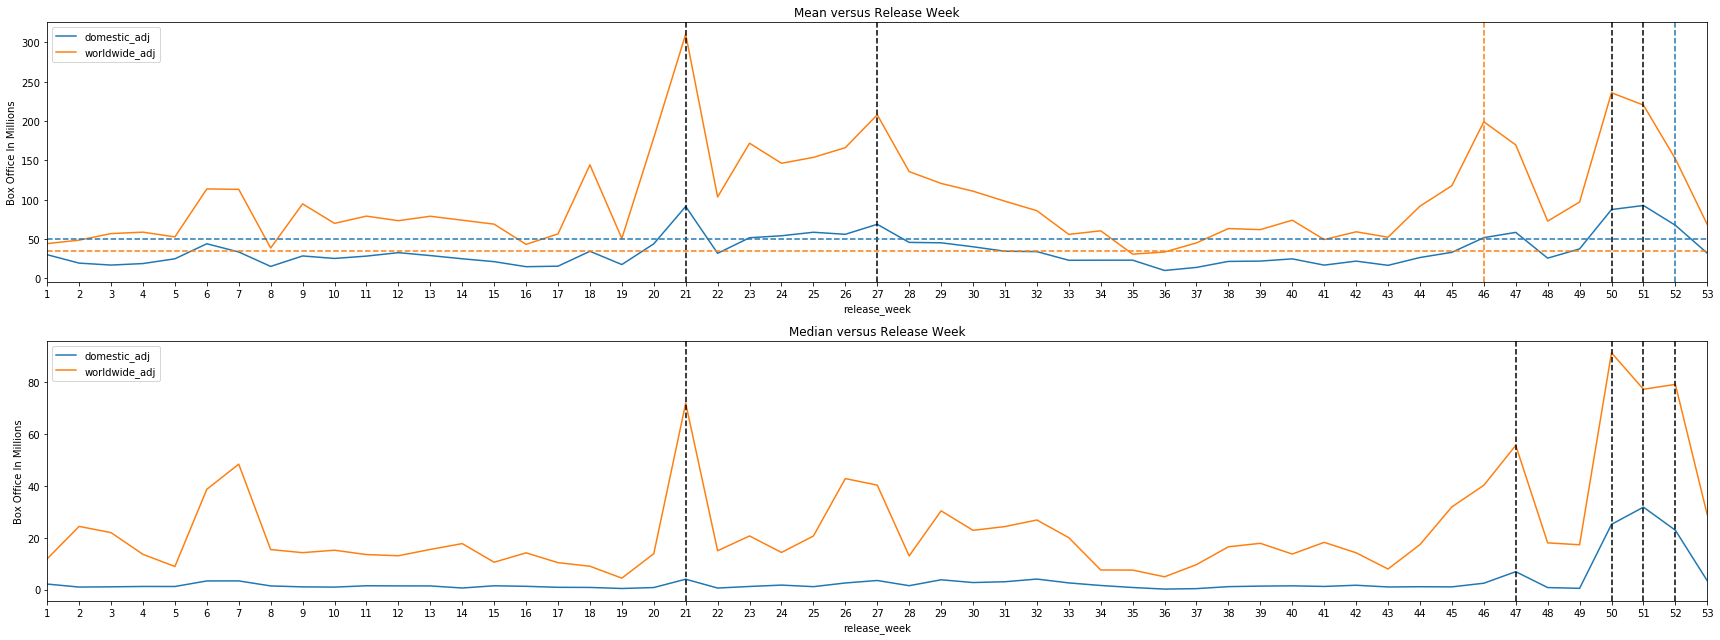

In [42]:
figure, (ax1, ax2) = plt.subplots(2, 1)

# Only use data with domestic box office
domestic = data[(data['domestic_adj'].notna()) & (data['domestic_adj'] > 0)]
worldwide = data[(data['worldwide_adj'].notna()) & (data['worldwide_adj'] > 0)]

# Mean groupbys
domestic_mean = domestic.groupby('release_week').mean() / 1000000
worldwide_mean = worldwide.groupby('release_week').mean() / 1000000

# Median groupbys
domestic_median = domestic.groupby('release_week').median() / 1000000
worldwide_median = worldwide.groupby('release_week').median() / 1000000

# Black verticals are weeks where both domestic and worldwide have the highest grosses
# Blue vertical is domestic
# Orange vertical is worldwide

domestic_mean.plot(y='domestic_adj', xticks=range(1,54), figsize=(24,9), ax=ax1, title='Mean versus Release Week')
worldwide_mean.plot(y='worldwide_adj', xticks=range(1,54), figsize=(24,9), ax=ax1)
ax1.set_ylabel('Box Office In Millions')
ax1.axvline(51, color='k', linestyle='--')
ax1.axvline(50, color='k', linestyle='--')
ax1.axvline(27, color='k', linestyle='--')
ax1.axvline(21, color='k', linestyle='--')
ax1.axvline(52, color='#1f77b4', linestyle='--')
ax1.axvline(46, color='#ff7f0e', linestyle='--')
ax1.axhline(domestic['domestic_adj'].mean() / 1000000, color='#ff7f0e', linestyle='--')
ax1.axhline(worldwide['domestic_adj'].mean() / 1000000, color='#1f77b4', linestyle='--')

domestic_median.plot(y='domestic_adj', xticks=range(1,54), figsize=(24,9), ax=ax2, title='Median versus Release Week')
worldwide_median.plot(y='worldwide_adj', xticks=range(1,54), figsize=(24,9), ax=ax2)
ax2.set_ylabel('Box Office In Millions')
ax2.axvline(51, color='k', linestyle='--')
ax2.axvline(52, color='k', linestyle='--')
ax2.axvline(50, color='k', linestyle='--')
ax2.axvline(47, color='k', linestyle='--')
ax2.axvline(21, color='k', linestyle='--')

plt.tight_layout()

In [ ]:
domestic_median.sort_values('domestic_adj', ascending=False)[:5]

In [ ]:
worldwide_median.sort_values('worldwide_adj', ascending=False)[:5]

In [ ]:
domestic_mean.sort_values('domestic_adj', ascending=False)[:5]

In [ ]:
worldwide_mean.sort_values('worldwide_adj', ascending=False)[:5]

So far, the data support what is commonly known about the best weeks to open large movies.

The highest earning weeks are the Christmas holidays (weeks 50-52), Thanksgiving (week 46-47), Memorial Day (week 21), and the start of summer (week 27).

The order of the weeks depends if we measure based on median box office grosses or the mean box office gross. 

Higher tails on big Memorial Day and Summer movies skew those weeks over 

In [ ]:
figure, (ax1, ax2) = plt.subplots(2, 1)

# Only use data with domestic box office
domestic_not_adjusted = data[(data['domestic'].notna()) & (data['domestic'] > 0)]
worldwide_not_adjusted = data[(data['worldwide'].notna()) & (data['worldwide'] > 0)]

# Mean groupbys
domestic_not_adjusted_mean = domestic_not_adjusted.groupby('release_week').mean() / 1000000
worldwide_not_adjusted_mean = worldwide_not_adjusted.groupby('release_week').mean() / 1000000

# Median groupbys
domestic_not_adjusted_median = domestic_not_adjusted.groupby('release_week').median() / 1000000
worldwide_not_adjusted_median = worldwide_not_adjusted.groupby('release_week').median() / 1000000

# Black verticals are weeks where both domestic and worldwide have the highest grosses
# Blue vertical is domestic
# Orange vertical is worldwide

domestic_not_adjusted_mean.plot(y='domestic', xticks=range(1,54), figsize=(24,9), ax=ax1, title='Unadjusted Mean versus Release Week')
worldwide_not_adjusted_mean.plot(y='worldwide', xticks=range(1,54), figsize=(24,9), ax=ax1)
ax1.set_ylabel('Box Office In Millions')
ax1.axvline(51, color='k', linestyle='--')
ax1.axvline(50, color='k', linestyle='--')
ax1.axvline(27, color='k', linestyle='--')
ax1.axvline(21, color='k', linestyle='--')
ax1.axvline(52, color='#1f77b4', linestyle='--')
ax1.axvline(46, color='#ff7f0e', linestyle='--')

domestic_not_adjusted_median.plot(y='domestic', xticks=range(1,54), figsize=(24,9), ax=ax2, title='Unadjusted Median versus Release Week')
worldwide_not_adjusted_median.plot(y='worldwide', xticks=range(1,54), figsize=(24,9), ax=ax2)
ax2.set_ylabel('Box Office In Millions')
ax2.axvline(51, color='k', linestyle='--')
ax2.axvline(52, color='k', linestyle='--')
ax2.axvline(50, color='k', linestyle='--')
ax2.axvline(47, color='k', linestyle='--')
ax2.axvline(21, color='k', linestyle='--')

plt.tight_layout()

This was a test to see if adjusted versus unadjusted box office figures would make a difference in our analysis.

There is not much difference between the two, so we will stick with the adjusted numbers.

In [ ]:
domestic.info()

In [ ]:
figure, (ax1, ax2) = plt.subplots(2, 1)

# Only use data with domestic box office
domestic = data[(data['domestic_adj'].notna()) & (data['domestic_adj'] > 0)]
# worldwide = data[(data['worldwide_adj'].notna()) & (data['worldwide_adj'] > 0)]

# Mean groupbys
domestic_mean = domestic.groupby('release_week').mean() / 1000000
# worldwide_mean = worldwide.groupby('release_week').mean() / 1000000

# Median groupbys
domestic_median = domestic.groupby('release_week').median() / 1000000
# worldwide_median = worldwide.groupby('release_week').median() / 1000000

# Black verticals are weeks where both domestic and worldwide have the highest grosses
# Blue vertical is domestic
# Orange vertical is worldwide

domestic_mean.plot(y='domestic_adj', xticks=range(1,54), yticks=range(0, 100, 20), figsize=(24,9), ax=ax1, title='Mean versus Release Week')
# worldwide_mean.plot(y='worldwide_adj', xticks=range(1,54), figsize=(24,9), ax=ax1)
ax1.set_ylabel('Box Office In Millions')

for value in domestic_mean.sort_values('domestic_adj', ascending=False).index[:5]:
    ax1.axvline(value, color='k', linestyle='--')

#ax1.axvline(51, color='k', linestyle='--')
#ax1.axvline(50, color='k', linestyle='--')
#ax1.axvline(27, color='k', linestyle='--')
#ax1.axvline(21, color='k', linestyle='--')
#ax1.axvline(52, color='k', linestyle='--')
# ax1.axvline(46, color='#ff7f0e', linestyle='--')
ax1.axhline(domestic['domestic_adj'].mean() / 1000000, color='k', linestyle='--')
# ax1.axhline(worldwide['domestic_adj'].mean() / 1000000, color='#1f77b4', linestyle='--')

domestic_median.plot(y='domestic_adj', xticks=range(1,54), yticks=range(0, 100, 20), figsize=(24,9), ax=ax2, sharey=True, title='Median versus Release Week')
# worldwide_median.plot(y='worldwide_adj', xticks=range(1,54), figsize=(24,9), ax=ax2)
ax2.set_ylabel('Box Office In Millions')

for value in domestic_median.sort_values('domestic_adj', ascending=False).index[:5]:
    ax2.axvline(value, color='k', linestyle='--')
    
#ax2.axvline(51, color='k', linestyle='--')
#ax2.axvline(52, color='k', linestyle='--')
#ax2.axvline(50, color='k', linestyle='--')
#ax2.axvline(47, color='k', linestyle='--')
#ax2.axvline(32, color='k', linestyle='--')
ax2.axhline(domestic['domestic_adj'].median() / 1000000, color='k', linestyle='--')

plt.tight_layout()

In [ ]:
print("The mean domestic box office value across all years and release weeks is", domestic['domestic_adj'].mean() / 1000000, "million dollars")
print("The median domestic box office value across all years and release weeks is", domestic['domestic_adj'].median() / 1000000, "million dollars")

In [ ]:
dom_sort = domestic.sort_values('domestic_adj', ascending=True)

dom_sort.tail()

In [ ]:
dom_sort.plot(x='release_date', y=['domestic_adj', 'budget_adj'], kind='line', figsize=(24, 12))

In [ ]:
dom_sort['domestic_gross_profit'] = dom_sort['domestic_adj'] - dom_sort['budget_adj']

dom_sort.plot(x='release_date', y='domestic_gross_profit', kind='line', figsize=(24, 12))

In [ ]:
dom_sort_with_budget = dom_sort[(dom_sort['budget_adj'].notna()) & dom_sort['budget_adj'] > 0]

dom_sort_with_budget.info()

In [ ]:
dom_sort_with_budget['domestic_gross_profit'] = dom_sort_with_budget['domestic_adj'] - dom_sort_with_budget['budget_adj']

fig, ax1 = plt.subplots(1, 1)

dom_sort_with_budget.plot(x='release_date', y='domestic_gross_profit', kind='line', figsize=(24, 12), ax=ax1)

ax1.axhline(0, color='k', linestyle='--')

In [ ]:
dom_sort_with_budget['domestic_gross_profit'].sort_values(ascending=True)

# Profitability Equation

It is difficult to determine exactly how much studios spend on marketing their movies. An article at [How Stuff Works](https://entertainment.howstuffworks.com/movie-cost1.htm) cites that marketing spend is typically around 50% of the production budget of a movie.

According to this article on [The Week](https://theweek.com/articles/647394/when-buy-movie-ticket-where-does-that-money), movie studios keep about 60% of theatrical money (while movie theaters get the other 40%). Once you account for 10% of that money going to pay distributors, movie studios keep about 50% of total theatrical money.

To come up with a profitability equation, we will use these numbers. We will say a movie broke even if it grossed three times its production budget domestically. 

Total spend = 150% production budget (adding 50% of production budget on top for marketing)
Total earnings = 0.5 * domestic box office

We want to analyze where Total spend = Total earnings, as this is the breakeven point.

1.5 * production budget = 0.5 * domestic box office -- is the breakeven point

So domestic box office = 3 * production budget

Another estimate from [Gizmodo](https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305) is that a movie breaks even when it earns twice its production budget worldwide. Since we have far more data points with domestic box office, we will stick to the domestic calculations for now. But a deeper dive could be explored if more worldwide figures were found.

## Import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

data = data[['title', 'release_week', 'release_year', 'release_date', 'domestic_adj', 'worldwide_adj', 'genres_mojo', 'budget_adj', 'domestic', 'worldwide']]

data.head(10)

## Examine data

In [ ]:
data['breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']

# Only 1075 movies out of 17,759 have broken even
data['breakeven'].sum()

In [ ]:
data_grp = data[data['breakeven'] == True].groupby('release_year')

In [ ]:
# The number of movies each year that breaks even has increased dramatically
data_grp['breakeven'].count().plot()

In [ ]:
data_grp3 = data.groupby('release_year')

# However, the number of movies released each year has also increased
data_grp3['release_year'].count().plot()

In [ ]:
# Controlling for number of movies released, the "average" number of breakeven movies seems to be declining in recent years
(data_grp2['breakeven'].sum() / data_grp2['breakeven'].count() * 100).plot()

# Looking At Worldwide Data

What happens if we look at how many movies break even based on worldwide totals?

In our case, a movie will breakeven if its worldwide box office is twice its production budget.

## Import needed libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

data = data[['title', 'release_week', 'release_year', 'release_date', 'domestic_adj', 'worldwide_adj', 'genres_mojo', 'budget_adj', 'domestic', 'worldwide']]

data = data[data['worldwide_adj'].notnull() & data['worldwide_adj'] > 0]

data.info()

In [ ]:
data['breakeven'] = data['worldwide_adj'] >= 2 * data['budget_adj']

data_grp = data.groupby('release_year')

In [ ]:
data_grp['breakeven'].sum().plot()

In [ ]:
data_grp['release_year'].count().plot()

In [ ]:
# Percentage of movies each year that break even
(data_grp['breakeven'].sum() / data_grp['breakeven'].count() * 100).plot()

In [ ]:
data_grp['release_year'].count()

# Combining domestic and worldwide into one graph

## Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

data = data[['title', 'release_week', 'release_year', 'release_date', 'domestic_adj', 'worldwide_adj', 'genres_mojo', 'budget_adj', 'domestic', 'worldwide']]

#data = data[data['worldwide_adj'].notnull() & data['worldwide_adj'] > 0]

data.info()

In [ ]:
data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']
data['worldwide_breakeven'] = data['worldwide_adj'] >= 2 * data['budget_adj']

In [ ]:
domestic = data[data['domestic_adj'].notnull() & data['domestic_adj'] > 0]

domestic_grp = domestic.groupby('release_year')

(domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100).plot()

In [ ]:
# We have 17,759 movies that made money domestically
domestic.info()

In [ ]:
worldwide = data[data['worldwide_adj'].notnull() & data['worldwide_adj'] > 0]

worldwide_grp = worldwide.groupby('release_year')

(worldwide_grp['worldwide_breakeven'].sum() / worldwide_grp['worldwide_breakeven'].count() * 100).plot()

In [ ]:
# We have 9,915 movies that made money worldwide.
worldwide.info()

In [ ]:
# Movies that earn money overseas have a much better chance of breaking even than those that are only domestic.

figure, ax1 = plt.subplots(1, 1)

(domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100).plot(figsize=(24,9), ax=ax1, title="Breakeven Percentages By Year")
(worldwide_grp['worldwide_breakeven'].sum() / worldwide_grp['worldwide_breakeven'].count() * 100).plot(figsize=(24,9), ax=ax1)

plt.tight_layout()

In [ ]:
# I want to be able to subtract the domestic breakeven percentage from the worldwide percentage to get a single line

subtraction = (worldwide_grp['worldwide_breakeven'].sum() / worldwide_grp['worldwide_breakeven'].count() * 100) - (domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100)

subtraction.plot(figsize=(24,9), title="Average Difference In Breakeven Percentages By Year (Worldwide - Domestic)")

# Decade Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.options.display.max_rows = 400
pd.options.display.max_columns = 50

## Import dataset

In [ ]:
data = pd.read_csv('cleaned_movie_data.csv', parse_dates=['release_date'])

data = data[['title', 'release_week', 'release_year', 'release_date', 'domestic_adj', 'worldwide_adj', 'genres_mojo', 'budget_adj', 'domestic', 'worldwide']]

data['release_decade'] = data['release_year'].apply(lambda x: x // 10 * 10)

# data = data[data['worldwide_adj'].notnull() & data['worldwide_adj'] > 0]

data.info()

In [ ]:
data['release_decade'].value_counts(dropna=False)

In [ ]:
data['domestic_breakeven'] = data['domestic_adj'] >= 3 * data['budget_adj']
data['worldwide_breakeven'] = data['worldwide_adj'] >= 2 * data['budget_adj']

In [ ]:
domestic = data[data['domestic_adj'].notnull() & data['domestic_adj'] > 0]

domestic_grp = domestic.groupby('release_decade')

(domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100).plot()

In [ ]:
# We have 17,759 movies that made money domestically
domestic.info()

In [ ]:
domestic_grp_year = domestic.groupby('release_year')

(domestic_grp_year['domestic_breakeven'].sum() / domestic_grp_year['domestic_breakeven'].count() * 100).plot()

In [ ]:
worldwide = data[data['worldwide_adj'].notnull() & data['worldwide_adj'] > 0]

worldwide_grp = worldwide.groupby('release_decade')

(worldwide_grp['worldwide_breakeven'].sum() / worldwide_grp['worldwide_breakeven'].count() * 100).plot()

In [ ]:
# We have 9,915 movies that made money worldwide.
worldwide.info()

In [ ]:
# Movies that earn money overseas have a much better chance of breaking even than those that are only domestic.

figure, ax1 = plt.subplots(1, 1)

(domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100).plot(figsize=(24,9), xticks=range(1910, 2020, 10), ax=ax1, title="Breakeven Percentages By Decade")
(worldwide_grp['worldwide_breakeven'].sum() / worldwide_grp['worldwide_breakeven'].count() * 100).plot(figsize=(24,9), ax=ax1)

plt.tight_layout()

In [ ]:
# I want to be able to subtract the domestic breakeven percentage from the worldwide percentage to get a single line

subtraction = (worldwide_grp['worldwide_breakeven'].sum() / worldwide_grp['worldwide_breakeven'].count() * 100) - (domestic_grp['domestic_breakeven'].sum() / domestic_grp['domestic_breakeven'].count() * 100)

subtraction.plot(xticks=range(1910, 2020, 10), figsize=(24,9), title="Average Difference In Breakeven Percentages By Decade (Worldwide - Domestic)")

Overall, movies that have a worldwide release are far more likely to breakeven than movies released only domestically. 

This could just be due to the size of the average worldwide movie compared to a domestic one.

For example, we would think the average movie released worldwide had a higher budget than one just released domestically.

In [ ]:
only_worldwide = data[((data['worldwide_adj'] > 0) & (data['worldwide_adj'].notnull())) & ((data['domestic_adj'] == 0) | (data['domestic_adj'].isnull()))]

In [ ]:
only_worldwide['worldwide_adj'].mean()

In [ ]:
and_worldwide = data[(data['worldwide_adj'] > 0) & (data['worldwide_adj'].notnull())]

In [ ]:
and_worldwide['worldwide_adj'].mean()

In [ ]:
only_domestic = data[((data['domestic_adj'] > 0) & (data['domestic_adj'].notnull())) & ((data['worldwide_adj'] == 0) | (data['worldwide_adj'].isnull()))]

In [ ]:
print("Average box office for only released domestically", only_domestic['domestic_adj'].mean())
print("Average budget for only released domestically", only_domestic['budget_adj'].mean())
print("Average profit for only released domestically", (only_domestic['domestic_adj'] - 3 * domestic['budget_adj']).mean())

In [ ]:
print("Average box office for anthing with a worldwide release", and_worldwide['worldwide_adj'].mean())
print("Average budget for for anthing with a worldwide release", and_worldwide['budget_adj'].mean())
print("Average profit for for anthing with a worldwide release", (and_worldwide['worldwide_adj'] - 2 * and_worldwide['budget_adj']).mean())

Movies with a worldwide footprint make more money.

In [ ]:
data_grp = data.groupby('release_year')

In [ ]:
figure, ax1 = plt.subplots(1, 1)

(data_grp['domestic_breakeven'].sum() / data_grp['domestic_breakeven'].count() * 100).plot(figsize=(24,9), ax=ax1, title="Domestic Breakeven Percentages By Year")
(data_grp['worldwide_breakeven'].sum() / data_grp['worldwide_breakeven'].count() * 100).plot(figsize=(24,9), ax=ax1, title="Worldwide Breakeven Percentages By Year")


In [ ]:
domestic[domestic['release_week'] == 6].sort_values('domestic_gross_2019', ascending=False)

In [ ]:
domestic.sort_values('domestic_gross_2019', ascending=False)

In [ ]:
domestic_grp_no_mean = domestic.groupby('release_week')
domestic_grp_no_mean.sort_values('domestic_gross_2019', ascending=False)

In [ ]:
comedy = domestic[domestic['genres_mojo'].str.contains('Comedy', na=False)]
romance = domestic[domestic['genres_mojo'].str.contains('Roman', na=False)]
action = domestic[domestic['genres_mojo'].str.contains('Action', na=False)]
sci_fi = domestic[domestic['genres_mojo'].str.contains('Sci-Fi', na=False)]
fantasy = domestic[domestic['genres_mojo'].str.contains('Fantasy', na=False)]
horror = domestic[domestic['genres_mojo'].str.contains('Horror', na=False)]
animation = domestic[domestic['genres_mojo'].str.contains('Animat', na=False)]

In [ ]:
comedy.index

In [ ]:
comedy.groupby('release_week')['domestic_gross_2019'].mean().max()/30

In [ ]:
print(comedy_gb.head())

In [ ]:
comedy.plot(x='release_week', y='domestic_gross_2019', kind='bar')

In [ ]:
romance.plot(x='release_week', y='domestic_gross_2019', kind='scatter')
action.plot(x='release_week', y='domestic_gross_2019', kind='scatter')
sci_fi.plot(x='release_week', y='domestic_gross_2019', kind='scatter')
fantasy.plot(x='release_week', y='domestic_gross_2019', kind='scatter')
horror.plot(x='release_week', y='domestic_gross_2019', kind='scatter')
animation.plot(x='release_week', y='domestic_gross_2019', kind='scatter')

In [ ]:
all_by_week=movies1.groupby('week_number')
action_by_week=action.groupby('week_number')
animation_by_week=animation.groupby('week_number')
comedy_by_week=comedy.groupby('week_number')
fantasy_by_week=fantasy.groupby('week_number')
horror_by_week=horror.groupby('week_number')
romance_by_week=romance.groupby('week_number')
scifi_by_week=scifi.groupby('week_number')

In [ ]:
# pandas_profiling.ProfileReport(outer_merged)

# Test

In [ ]:
figure, ax1 = plt.subplots(1,1)

for genre in [adventure, action, drama, comedy, thriller_suspense, horror]:
    grp = genre.groupby('release_decade').mean() / 1000000
    grp.plot(y='domestic_adj', xticks=range(1910, 2020, 10), figsize=(18,9), ax=ax1, title='Mean Domestic Gross By Genre And Decade', linewidth=3)
    
ax1.set_ylabel('Domestic Gross In Millions')
ax1.legend(['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'])
plt.tight_layout()    

Key Takeaways:
- We're missing a lot of genre labeling before 1950.
- It still seems that Adventure, Action, and Horror are the biggest winners.

In [ ]:
figure, ax1 = plt.subplots(1,1)

for genre in ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']:
    grp = data[data[genre]].groupby('release_week').mean() / 1000000
    grp.plot(y='domestic_adj', xticks=range(1, 54), figsize=(18,9), ax=ax1, title='Mean Domestic Gross By Genre And Release Week', linewidth=3)
    
ax1.set_ylabel('Domestic Gross In Millions')
ax1.legend(['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'])
plt.tight_layout()   

In [ ]:
figure, ax1 = plt.subplots(1,1)

for genre in [adventure, action, drama, comedy, thriller_suspense, horror]:
    grp = genre.groupby('release_week').mean() / 1000000
    grp.plot(y='domestic_adj', xticks=range(1, 54), figsize=(18,9), ax=ax1, title='Mean Domestic Gross By Genre And Release Week', linewidth=3)
    
ax1.set_ylabel('Domestic Gross In Millions')
ax1.legend(['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror'])
plt.tight_layout()    

In [ ]:
dfs = [adventure, action, drama, comedy, thriller_suspense, horror]
genres = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']

for df, genre in zip(dfs, genres):
    print('{0} has a domestic mean of {1:.1f} million dollars'.format(genre, df['domestic_adj'].mean() / 1000000))

Key Takeaways:
- In aggregate it seems the top selling genres are Adventure, Action, and Horror
- End of spring into summer and winter are the best box office times of the year
- Horror has a big bump around the Winter Holidays

In [ ]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(18,9), sharey=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

genres = [adventure, action, drama, comedy, thriller_suspense, horror]
names = ['adventure', 'action', 'drama', 'comedy', 'thriller_suspense', 'horror']

for axis, genre, name in zip(axes_list, genres, names):
    genre.hist('release_decade', ax=axis)
    axis.set_ylabel('Count of Movies By Genre')
    axis.set_title(name)

plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Draw a graph with pandas and keep what's returned
ax = outer_merged.plot(kind='scatter', x='production_budget_mojo_2019', y='production_budget_numbers_2019')

# Set the x scale because otherwise it goes into weird negative numbers
# ax.set_xlim(outer_merged.index)

# Set the x-axis label
ax.set_xlabel("production_budget_mojo_2019")

# Set the y-axis label
ax.set_ylabel("production_budget_numbers_2019")

In [ ]:
# Draw a graph with pandas and keep what's returned
ax = outer_merged.plot(kind='scatter', x='domestic_gross_mojo_2019', y='domestic_gross_numbers_2019')

# Set the x scale because otherwise it goes into weird negative numbers
# ax.set_xlim(outer_merged.index)

# Set the x-axis label
ax.set_xlabel("domestic_gross_mojo_2019")

# Set the y-axis label
ax.set_ylabel("domestic_gross_numbers_2019")

In [ ]:
outer_merged.columns

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1)
ax1 = outer_merged.plot(kind='scatter', x='production_budget_mojo_2019', y='production_budget_numbers_2019')
ax1.set_xlabel("production_budget_mojo_2019")
ax1.set_ylabel("production_budget_numbers_2019")

#ax2 = fig.add_subplot(1, 3, 2)
#ax2.plot(kind='scatter', x='domestic_gross_mojo_2019', y='domestic_gross_numbers_2019')
#ax2.set_xlabel("domestic_gross_mojo_2019")
#ax2.set_ylabel("domestic_gross_numbers_2019")

#ax3 = fig.add_subplot(1, 3, 3)
#ax3.plot(kind='scatter', x='worldwide_gross_mojo_2019', y='worldwide_gross_numbers_2019')
#ax3.set_xlabel("worldwide_gross_mojo_2019")
#ax3.set_ylabel("worldwide_gross_numbers_2019")

#ax2 = fig.add_subplot(4, 4, 2)
#ax2 = outer_merged.plot(kind='scatter', x='domestic_gross_mojo_2019', y='domestic_gross_numbers_2019')
#ax2.set_xlabel("domestic_gross_mojo_2019")
#ax2.set_ylabel("domestic_gross_numbers_2019")



In [ ]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
ax1.plot(kind='scatter', x=outer_merged['production_budget_mojo_2019'], y=outer_merged['production_budget_numbers_2019'])
ax1.set_xlabel("production_budget_mojo_2019")
ax1.set_ylabel("production_budget_numbers_2019")

ax2.plot(kind='scatter', x=outer_merged['domestic_gross_mojo_2019'], y=outer_merged['domestic_gross_numbers_2019'])
ax2.set_xlabel("domestic_gross_mojo_2019")
ax2.set_ylabel("domestic_gross_numbers_2019")

ax3.plot(kind='scatter', x=outer_merged['worldwide_gross_mojo_2019'], y=outer_merged['worldwide_gross_numbers_2019'])
ax3.set_xlabel("worldwide_gross_mojo_2019")
ax3.set_ylabel("worldwide_gross_numbers_2019")

In [ ]:
DataFrame.plot(x=None, y=None, kind='line', ax=None, subplots=False, sharex=None, sharey=False, layout=None, figsize=None, use_index=True, title=None, grid=None, legend=True, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr=None, xerr=None, secondary_y=False, sort_columns=False, **kwds)

In [ ]:
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,10))

outer_merged.plot(x='production_budget_mojo_2019', y='production_budget_numbers_2019', kind='scatter', ax=ax1)
outer_merged.plot(x='domestic_gross_mojo_2019', y='domestic_gross_numbers_2019', kind='scatter', ax=ax2)
outer_merged.plot(x='worldwide_gross_mojo_2019', y='worldwide_gross_numbers_2019', kind='scatter', ax=ax3)

# Genres

In [ ]:
# outer_merged['Comedy'] = outer_merged['genres_mojo'].str.contains('Comedy', na=False)
# outer_merged['Romance'] = outer_merged['genres_mojo'].str.contains('Roman', na=False)
# outer_merged['Drama'] = outer_merged['genres_mojo'].str.contains('Drama', na=False)
# outer_merged['Thriller'] = outer_merged['genres_mojo'].str.contains('Thriller', na=False)
# outer_merged['Sci-Fi'] = outer_merged['genres_mojo'].str.contains('Sci-Fi', na=False)
# outer_merged['Action'] = outer_merged['genres_mojo'].str.contains('Action', na=False)
# outer_merged['Period'] = outer_merged['genres_mojo'].str.contains('Period', na=False)
# outer_merged['Sports'] = outer_merged['genres_mojo'].str.contains('Sports', na=False)
# outer_merged['Adventure'] = outer_merged['genres_mojo'].str.contains('Adventure', na=False)
# outer_merged['Fantasy'] = outer_merged['genres_mojo'].str.contains('Fantasy', na=False)
# outer_merged['Western'] = outer_merged['genres_mojo'].str.contains('Western', na=False)
# outer_merged['Horror'] = outer_merged['genres_mojo'].str.contains('Horror', na=False)
# outer_merged['War'] = outer_merged['genres_mojo'].str.contains('War', na=False)
# outer_merged['Family'] = outer_merged['genres_mojo'].str.contains('Family', na=False)
# outer_merged['Crime'] = outer_merged['genres_mojo'].str.contains('Crime', na=False)
# outer_merged['Animation'] = outer_merged['genres_mojo'].str.contains('Animation', na=False)

In [ ]:
comedy = outer_merged[outer_merged['genres_mojo'].str.contains('Comedy', na=False)]
romance = outer_merged[outer_merged['genres_mojo'].str.contains('Roman', na=False)]
action = outer_merged[outer_merged['genres_mojo'].str.contains('Action', na=False)]
sci_fi = outer_merged[outer_merged['genres_mojo'].str.contains('Sci-Fi', na=False)]
fantasy = outer_merged[outer_merged['genres_mojo'].str.contains('Fantasy', na=False)]
horror = outer_merged[outer_merged['genres_mojo'].str.contains('Horror', na=False)]
animation = outer_merged[outer_merged['genres_mojo'].str.contains('Animat', na=False)]

In [ ]:
comedy.plot(x='release_week', y='production_budget_mojo_2019', kind='line')
comedy.plot(x='release_week', y='domestic_gross_mojo_2019', kind='line')

In [ ]:
outer_merged.groupby("genres_mojo").plot(x="release_week", y="domestic_gross_mojo_2019")